# GM-VAE for KI

In [1]:
num_epochs=10000
num_components=2  # only the starting number of components

## Import Libraries

In [3]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/yangz2/projects/modules/')
from log_training_progress import email_training_progress

## Load data

In [4]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [6]:
chunks_int = open_json_as_nparray('/home/yangz2/projects/gmvae_and_gmmvae/data/mma_chunks_int.json')
chunks_onehot = np.eye(len(np.unique(chunks_int)))[chunks_int]
chunks_onehot.shape

(3330, 16, 16, 17)

In [7]:
chunks_onehot = chunks_onehot.reshape(
    chunks_onehot.shape[0], 
    chunks_onehot.shape[1] * chunks_onehot.shape[2] * chunks_onehot.shape[3]
)
chunks_onehot.shape

(3330, 4352)

In [8]:
def get_random_labels(num_components, size):
    return np.random.randint(num_components, size=size)

## Input Parameters

In [12]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=4352, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=1, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [13]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [14]:
def get_train_dl_and_valid_dl(chunks, labels):

    valid_indices = np.random.randint(len(chunks), size=100)
    train_chunks, valid_chunks = chunks, chunks[valid_indices]
    train_labels, valid_labels = labels, labels[valid_indices]

    train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
    valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

    train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)
    
    return train_dl, valid_dl

## Train Model

In [ ]:
for num_components in [2, 4, 6, 8]:
    
    args.num_classes = num_components
    gmvae = GMVAE(args)
    
    labels = get_random_labels(num_components, len(chunks_onehot))
    train_dl, valid_dl = get_train_dl_and_valid_dl(chunks_onehot, labels)
    gmvae.train(train_dl, valid_dl)
    
    torch.save(
        gmvae.network.state_dict(),
        f'../qualitative_clustering_analysis/mma_gmvae_{num_components}_{num_epochs}.pth'
    )
    
    email_training_progress(f'GM-VAE with {num_components} components has finished training!')
email_training_progress('Shutdown VM now!')

(Epoch 1 / 10000) Train_Loss: 695.724; Val_Loss: 447.055   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: 0.000; Val_NMI: 0.000
(Epoch 2 / 10000) Train_Loss: 455.680; Val_Loss: 411.839   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3 / 10000) Train_Loss: 405.094; Val_Loss: 367.036   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4 / 10000) Train_Loss: 380.332; Val_Loss: 356.365   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5 / 10000) Train_Loss: 374.073; Val_Loss: 337.462   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6 / 10000) Train_Loss: 360.710; Val_Loss: 322.608   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7 / 10000) Train_Loss: 352.437; Val_Loss: 316.945   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8 / 10000) Train_Loss: 341.057; Val_Loss: 305.969   Train_ACC: 50.991; Val_ACC: 53.0

(Epoch 64 / 10000) Train_Loss: 194.995; Val_Loss: 158.223   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 65 / 10000) Train_Loss: 193.723; Val_Loss: 160.337   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 66 / 10000) Train_Loss: 192.603; Val_Loss: 159.092   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 67 / 10000) Train_Loss: 190.594; Val_Loss: 155.509   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 68 / 10000) Train_Loss: 184.841; Val_Loss: 150.335   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 69 / 10000) Train_Loss: 182.422; Val_Loss: 156.353   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 70 / 10000) Train_Loss: 185.131; Val_Loss: 153.579   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 71 / 10000) Train_Loss: 180.918; Val_Loss: 153.624   Train_ACC: 50.991; Val_

(Epoch 127 / 10000) Train_Loss: 128.003; Val_Loss: 114.299   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 128 / 10000) Train_Loss: 138.871; Val_Loss: 105.659   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 129 / 10000) Train_Loss: 127.853; Val_Loss: 103.854   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 130 / 10000) Train_Loss: 129.010; Val_Loss: 102.135   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 131 / 10000) Train_Loss: 122.838; Val_Loss: 101.451   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 132 / 10000) Train_Loss: 125.755; Val_Loss: 101.845   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 133 / 10000) Train_Loss: 124.043; Val_Loss: 100.153   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 134 / 10000) Train_Loss: 122.488; Val_Loss: 100.737   Train_ACC: 50.9

(Epoch 190 / 10000) Train_Loss: 100.961; Val_Loss: 82.389   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 191 / 10000) Train_Loss: 99.693; Val_Loss: 83.316   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 192 / 10000) Train_Loss: 96.631; Val_Loss: 81.022   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 193 / 10000) Train_Loss: 98.421; Val_Loss: 81.311   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 194 / 10000) Train_Loss: 95.077; Val_Loss: 81.773   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 195 / 10000) Train_Loss: 95.130; Val_Loss: 84.522   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 196 / 10000) Train_Loss: 98.746; Val_Loss: 82.951   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 197 / 10000) Train_Loss: 121.057; Val_Loss: 91.244   Train_ACC: 50.991; Val_ACC: 5

(Epoch 253 / 10000) Train_Loss: 90.515; Val_Loss: 72.550   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 254 / 10000) Train_Loss: 79.877; Val_Loss: 68.424   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 255 / 10000) Train_Loss: 78.758; Val_Loss: 68.879   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 256 / 10000) Train_Loss: 79.283; Val_Loss: 72.044   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 257 / 10000) Train_Loss: 91.731; Val_Loss: 70.935   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 258 / 10000) Train_Loss: 82.563; Val_Loss: 71.594   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 259 / 10000) Train_Loss: 85.422; Val_Loss: 70.211   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 260 / 10000) Train_Loss: 79.857; Val_Loss: 68.469   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 317 / 10000) Train_Loss: 75.231; Val_Loss: 66.145   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 318 / 10000) Train_Loss: 72.406; Val_Loss: 59.774   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 319 / 10000) Train_Loss: 69.542; Val_Loss: 63.531   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 320 / 10000) Train_Loss: 70.838; Val_Loss: 60.593   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 321 / 10000) Train_Loss: 74.725; Val_Loss: 61.495   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 322 / 10000) Train_Loss: 76.610; Val_Loss: 70.078   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 323 / 10000) Train_Loss: 118.347; Val_Loss: 82.041   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 324 / 10000) Train_Loss: 106.076; Val_Loss: 74.785   Train_ACC: 50.991; Val_ACC: 5

(Epoch 381 / 10000) Train_Loss: 70.302; Val_Loss: 58.566   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 382 / 10000) Train_Loss: 65.599; Val_Loss: 58.093   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 383 / 10000) Train_Loss: 72.843; Val_Loss: 60.978   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 384 / 10000) Train_Loss: 64.983; Val_Loss: 60.330   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 385 / 10000) Train_Loss: 75.478; Val_Loss: 60.150   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 386 / 10000) Train_Loss: 71.216; Val_Loss: 61.857   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 387 / 10000) Train_Loss: 68.234; Val_Loss: 60.239   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 388 / 10000) Train_Loss: 73.448; Val_Loss: 59.631   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 445 / 10000) Train_Loss: 60.696; Val_Loss: 53.683   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 446 / 10000) Train_Loss: 64.296; Val_Loss: 59.752   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 447 / 10000) Train_Loss: 61.739; Val_Loss: 54.877   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 448 / 10000) Train_Loss: 60.935; Val_Loss: 55.114   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 449 / 10000) Train_Loss: 63.868; Val_Loss: 55.126   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 450 / 10000) Train_Loss: 66.131; Val_Loss: 56.279   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 451 / 10000) Train_Loss: 65.960; Val_Loss: 57.136   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 452 / 10000) Train_Loss: 64.508; Val_Loss: 55.163   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 509 / 10000) Train_Loss: 57.188; Val_Loss: 51.445   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 510 / 10000) Train_Loss: 61.465; Val_Loss: 56.691   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 511 / 10000) Train_Loss: 56.508; Val_Loss: 49.081   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 512 / 10000) Train_Loss: 54.710; Val_Loss: 49.852   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 513 / 10000) Train_Loss: 59.256; Val_Loss: 50.463   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 514 / 10000) Train_Loss: 53.327; Val_Loss: 50.190   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 515 / 10000) Train_Loss: 55.248; Val_Loss: 48.777   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 516 / 10000) Train_Loss: 55.026; Val_Loss: 51.970   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 573 / 10000) Train_Loss: 76.881; Val_Loss: 61.553   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 574 / 10000) Train_Loss: 66.292; Val_Loss: 53.923   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 575 / 10000) Train_Loss: 58.797; Val_Loss: 53.622   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 576 / 10000) Train_Loss: 55.889; Val_Loss: 49.162   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 577 / 10000) Train_Loss: 56.551; Val_Loss: 48.932   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 578 / 10000) Train_Loss: 53.535; Val_Loss: 47.351   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 579 / 10000) Train_Loss: 54.906; Val_Loss: 49.230   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 580 / 10000) Train_Loss: 53.009; Val_Loss: 48.072   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 637 / 10000) Train_Loss: 61.652; Val_Loss: 49.652   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 638 / 10000) Train_Loss: 54.066; Val_Loss: 46.194   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 639 / 10000) Train_Loss: 51.556; Val_Loss: 45.785   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 640 / 10000) Train_Loss: 55.833; Val_Loss: 73.790   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 641 / 10000) Train_Loss: 80.698; Val_Loss: 53.505   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 642 / 10000) Train_Loss: 69.307; Val_Loss: 50.804   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 643 / 10000) Train_Loss: 57.183; Val_Loss: 47.621   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 644 / 10000) Train_Loss: 50.386; Val_Loss: 45.216   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 701 / 10000) Train_Loss: 123.824; Val_Loss: 70.598   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 702 / 10000) Train_Loss: 73.687; Val_Loss: 52.777   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 703 / 10000) Train_Loss: 56.263; Val_Loss: 48.453   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 704 / 10000) Train_Loss: 67.048; Val_Loss: 50.964   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 705 / 10000) Train_Loss: 57.166; Val_Loss: 47.612   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 706 / 10000) Train_Loss: 56.440; Val_Loss: 45.781   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 707 / 10000) Train_Loss: 54.578; Val_Loss: 47.102   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 708 / 10000) Train_Loss: 51.383; Val_Loss: 46.058   Train_ACC: 50.991; Val_ACC: 53

(Epoch 765 / 10000) Train_Loss: 46.956; Val_Loss: 43.749   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 766 / 10000) Train_Loss: 51.775; Val_Loss: 48.111   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 767 / 10000) Train_Loss: 68.827; Val_Loss: 57.840   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 768 / 10000) Train_Loss: 73.513; Val_Loss: 58.557   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 769 / 10000) Train_Loss: 80.145; Val_Loss: 54.792   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 770 / 10000) Train_Loss: 65.690; Val_Loss: 51.339   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 771 / 10000) Train_Loss: 52.019; Val_Loss: 45.013   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 772 / 10000) Train_Loss: 54.185; Val_Loss: 46.069   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 829 / 10000) Train_Loss: 45.615; Val_Loss: 42.136   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 830 / 10000) Train_Loss: 45.875; Val_Loss: 42.976   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 831 / 10000) Train_Loss: 48.292; Val_Loss: 42.611   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 832 / 10000) Train_Loss: 44.971; Val_Loss: 44.923   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 833 / 10000) Train_Loss: 47.886; Val_Loss: 42.964   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 834 / 10000) Train_Loss: 45.897; Val_Loss: 43.226   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 835 / 10000) Train_Loss: 45.525; Val_Loss: 41.990   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 836 / 10000) Train_Loss: 49.477; Val_Loss: 44.031   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 893 / 10000) Train_Loss: 52.637; Val_Loss: 46.219   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 894 / 10000) Train_Loss: 48.081; Val_Loss: 42.982   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 895 / 10000) Train_Loss: 49.158; Val_Loss: 46.655   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 896 / 10000) Train_Loss: 45.634; Val_Loss: 43.053   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 897 / 10000) Train_Loss: 46.071; Val_Loss: 41.088   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 898 / 10000) Train_Loss: 46.642; Val_Loss: 41.879   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 899 / 10000) Train_Loss: 46.858; Val_Loss: 43.401   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 900 / 10000) Train_Loss: 45.906; Val_Loss: 43.807   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 957 / 10000) Train_Loss: 90.159; Val_Loss: 58.634   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 958 / 10000) Train_Loss: 66.210; Val_Loss: 50.595   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 959 / 10000) Train_Loss: 62.316; Val_Loss: 49.649   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 960 / 10000) Train_Loss: 51.273; Val_Loss: 42.378   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 961 / 10000) Train_Loss: 45.685; Val_Loss: 41.551   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 962 / 10000) Train_Loss: 43.691; Val_Loss: 40.184   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 963 / 10000) Train_Loss: 44.005; Val_Loss: 41.075   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 964 / 10000) Train_Loss: 43.165; Val_Loss: 40.286   Train_ACC: 50.991; Val_ACC: 53.

(Epoch 1020 / 10000) Train_Loss: 49.875; Val_Loss: 40.836   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1021 / 10000) Train_Loss: 48.177; Val_Loss: 43.252   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1022 / 10000) Train_Loss: 44.240; Val_Loss: 42.398   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1023 / 10000) Train_Loss: 42.577; Val_Loss: 39.850   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1024 / 10000) Train_Loss: 42.942; Val_Loss: 41.288   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1025 / 10000) Train_Loss: 47.030; Val_Loss: 42.732   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1026 / 10000) Train_Loss: 46.811; Val_Loss: 41.535   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1027 / 10000) Train_Loss: 44.704; Val_Loss: 41.260   Train_ACC: 50.991; Val_

(Epoch 1083 / 10000) Train_Loss: 48.109; Val_Loss: 42.824   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1084 / 10000) Train_Loss: 44.624; Val_Loss: 40.927   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1085 / 10000) Train_Loss: 43.923; Val_Loss: 39.234   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1086 / 10000) Train_Loss: 42.614; Val_Loss: 40.021   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1087 / 10000) Train_Loss: 42.862; Val_Loss: 41.538   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1088 / 10000) Train_Loss: 49.876; Val_Loss: 53.431   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1089 / 10000) Train_Loss: 94.177; Val_Loss: 64.365   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1090 / 10000) Train_Loss: 72.461; Val_Loss: 53.206   Train_ACC: 50.991; Val_

(Epoch 1146 / 10000) Train_Loss: 43.068; Val_Loss: 39.391   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1147 / 10000) Train_Loss: 43.017; Val_Loss: 42.962   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1148 / 10000) Train_Loss: 46.574; Val_Loss: 42.825   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1149 / 10000) Train_Loss: 42.191; Val_Loss: 40.186   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1150 / 10000) Train_Loss: 51.114; Val_Loss: 43.875   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1151 / 10000) Train_Loss: 50.421; Val_Loss: 44.153   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1152 / 10000) Train_Loss: 44.907; Val_Loss: 41.692   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1153 / 10000) Train_Loss: 42.511; Val_Loss: 39.048   Train_ACC: 50.991; Val_

(Epoch 1209 / 10000) Train_Loss: 41.625; Val_Loss: 38.092   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1210 / 10000) Train_Loss: 50.846; Val_Loss: 63.347   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1211 / 10000) Train_Loss: 106.160; Val_Loss: 62.332   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1212 / 10000) Train_Loss: 69.931; Val_Loss: 50.411   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1213 / 10000) Train_Loss: 51.334; Val_Loss: 41.177   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1214 / 10000) Train_Loss: 51.956; Val_Loss: 43.200   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1215 / 10000) Train_Loss: 46.304; Val_Loss: 40.905   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1216 / 10000) Train_Loss: 42.312; Val_Loss: 38.384   Train_ACC: 50.991; Val

(Epoch 1272 / 10000) Train_Loss: 48.491; Val_Loss: 45.931   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1273 / 10000) Train_Loss: 44.508; Val_Loss: 42.536   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1274 / 10000) Train_Loss: 44.155; Val_Loss: 42.744   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1275 / 10000) Train_Loss: 42.363; Val_Loss: 37.380   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1276 / 10000) Train_Loss: 40.130; Val_Loss: 38.824   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1277 / 10000) Train_Loss: 40.797; Val_Loss: 39.026   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1278 / 10000) Train_Loss: 44.141; Val_Loss: 39.914   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1279 / 10000) Train_Loss: 46.789; Val_Loss: 41.651   Train_ACC: 50.991; Val_

(Epoch 1335 / 10000) Train_Loss: 41.804; Val_Loss: 36.780   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1336 / 10000) Train_Loss: 41.523; Val_Loss: 41.388   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1337 / 10000) Train_Loss: 39.976; Val_Loss: 37.637   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1338 / 10000) Train_Loss: 40.248; Val_Loss: 39.035   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1339 / 10000) Train_Loss: 39.798; Val_Loss: 38.681   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1340 / 10000) Train_Loss: 39.864; Val_Loss: 39.759   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1341 / 10000) Train_Loss: 52.594; Val_Loss: 43.734   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1342 / 10000) Train_Loss: 43.776; Val_Loss: 38.896   Train_ACC: 50.991; Val_

(Epoch 1398 / 10000) Train_Loss: 40.769; Val_Loss: 38.770   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1399 / 10000) Train_Loss: 43.463; Val_Loss: 39.991   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1400 / 10000) Train_Loss: 45.234; Val_Loss: 42.669   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1401 / 10000) Train_Loss: 48.301; Val_Loss: 47.116   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1402 / 10000) Train_Loss: 44.016; Val_Loss: 38.309   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1403 / 10000) Train_Loss: 44.338; Val_Loss: 38.754   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1404 / 10000) Train_Loss: 42.722; Val_Loss: 39.984   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1405 / 10000) Train_Loss: 43.814; Val_Loss: 40.774   Train_ACC: 50.991; Val_

(Epoch 1461 / 10000) Train_Loss: 38.885; Val_Loss: 41.447   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1462 / 10000) Train_Loss: 56.559; Val_Loss: 45.344   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1463 / 10000) Train_Loss: 53.777; Val_Loss: 44.754   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1464 / 10000) Train_Loss: 49.788; Val_Loss: 40.447   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1465 / 10000) Train_Loss: 47.367; Val_Loss: 40.339   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1466 / 10000) Train_Loss: 56.008; Val_Loss: 43.038   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1467 / 10000) Train_Loss: 47.121; Val_Loss: 41.854   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1468 / 10000) Train_Loss: 49.782; Val_Loss: 51.006   Train_ACC: 50.991; Val_

(Epoch 1524 / 10000) Train_Loss: 40.185; Val_Loss: 38.214   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1525 / 10000) Train_Loss: 40.945; Val_Loss: 38.934   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1526 / 10000) Train_Loss: 42.223; Val_Loss: 41.018   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1527 / 10000) Train_Loss: 53.647; Val_Loss: 45.968   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1528 / 10000) Train_Loss: 49.706; Val_Loss: 40.739   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1529 / 10000) Train_Loss: 50.484; Val_Loss: 47.890   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1530 / 10000) Train_Loss: 88.347; Val_Loss: 59.579   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1531 / 10000) Train_Loss: 61.896; Val_Loss: 54.555   Train_ACC: 50.991; Val_

(Epoch 1587 / 10000) Train_Loss: 39.821; Val_Loss: 40.664   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1588 / 10000) Train_Loss: 45.546; Val_Loss: 42.761   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1589 / 10000) Train_Loss: 42.114; Val_Loss: 37.885   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1590 / 10000) Train_Loss: 42.657; Val_Loss: 38.522   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1591 / 10000) Train_Loss: 41.512; Val_Loss: 37.940   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1592 / 10000) Train_Loss: 43.236; Val_Loss: 39.262   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1593 / 10000) Train_Loss: 44.716; Val_Loss: 40.950   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1594 / 10000) Train_Loss: 42.501; Val_Loss: 39.580   Train_ACC: 50.991; Val_

(Epoch 1650 / 10000) Train_Loss: 45.092; Val_Loss: 38.907   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1651 / 10000) Train_Loss: 44.393; Val_Loss: 43.596   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1652 / 10000) Train_Loss: 67.605; Val_Loss: 57.260   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1653 / 10000) Train_Loss: 73.086; Val_Loss: 48.173   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1654 / 10000) Train_Loss: 52.660; Val_Loss: 40.299   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1655 / 10000) Train_Loss: 47.577; Val_Loss: 41.030   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1656 / 10000) Train_Loss: 45.401; Val_Loss: 40.519   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1657 / 10000) Train_Loss: 40.565; Val_Loss: 36.818   Train_ACC: 50.991; Val_

(Epoch 1713 / 10000) Train_Loss: 48.698; Val_Loss: 43.282   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1714 / 10000) Train_Loss: 49.493; Val_Loss: 42.070   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1715 / 10000) Train_Loss: 45.647; Val_Loss: 39.745   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1716 / 10000) Train_Loss: 42.469; Val_Loss: 40.315   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1717 / 10000) Train_Loss: 49.280; Val_Loss: 42.273   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1718 / 10000) Train_Loss: 44.228; Val_Loss: 40.329   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1719 / 10000) Train_Loss: 41.410; Val_Loss: 39.487   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1720 / 10000) Train_Loss: 43.556; Val_Loss: 39.681   Train_ACC: 50.991; Val_

(Epoch 1776 / 10000) Train_Loss: 40.659; Val_Loss: 37.055   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1777 / 10000) Train_Loss: 41.673; Val_Loss: 37.781   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1778 / 10000) Train_Loss: 39.093; Val_Loss: 37.465   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1779 / 10000) Train_Loss: 39.826; Val_Loss: 37.118   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1780 / 10000) Train_Loss: 42.757; Val_Loss: 37.690   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1781 / 10000) Train_Loss: 40.219; Val_Loss: 40.691   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1782 / 10000) Train_Loss: 43.856; Val_Loss: 38.471   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1783 / 10000) Train_Loss: 42.469; Val_Loss: 38.188   Train_ACC: 50.991; Val_

(Epoch 1839 / 10000) Train_Loss: 39.551; Val_Loss: 37.671   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1840 / 10000) Train_Loss: 39.720; Val_Loss: 37.215   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1841 / 10000) Train_Loss: 38.055; Val_Loss: 35.804   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1842 / 10000) Train_Loss: 39.496; Val_Loss: 36.983   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1843 / 10000) Train_Loss: 39.908; Val_Loss: 40.691   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1844 / 10000) Train_Loss: 42.037; Val_Loss: 40.223   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1845 / 10000) Train_Loss: 46.293; Val_Loss: 39.247   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1846 / 10000) Train_Loss: 42.537; Val_Loss: 42.860   Train_ACC: 50.991; Val_

(Epoch 1902 / 10000) Train_Loss: 40.856; Val_Loss: 39.375   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1903 / 10000) Train_Loss: 40.415; Val_Loss: 36.409   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1904 / 10000) Train_Loss: 40.491; Val_Loss: 38.359   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1905 / 10000) Train_Loss: 39.257; Val_Loss: 36.068   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1906 / 10000) Train_Loss: 41.691; Val_Loss: 42.733   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1907 / 10000) Train_Loss: 57.784; Val_Loss: 46.495   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1908 / 10000) Train_Loss: 48.769; Val_Loss: 41.674   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1909 / 10000) Train_Loss: 43.755; Val_Loss: 38.671   Train_ACC: 50.991; Val_

(Epoch 1965 / 10000) Train_Loss: 41.673; Val_Loss: 36.355   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1966 / 10000) Train_Loss: 40.446; Val_Loss: 35.911   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1967 / 10000) Train_Loss: 42.240; Val_Loss: 41.135   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1968 / 10000) Train_Loss: 41.149; Val_Loss: 37.826   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1969 / 10000) Train_Loss: 40.637; Val_Loss: 38.916   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1970 / 10000) Train_Loss: 40.466; Val_Loss: 37.803   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1971 / 10000) Train_Loss: 41.137; Val_Loss: 37.807   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 1972 / 10000) Train_Loss: 40.250; Val_Loss: 37.587   Train_ACC: 50.991; Val_

(Epoch 2028 / 10000) Train_Loss: 46.044; Val_Loss: 39.027   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2029 / 10000) Train_Loss: 40.515; Val_Loss: 37.486   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2030 / 10000) Train_Loss: 43.505; Val_Loss: 37.508   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2031 / 10000) Train_Loss: 40.610; Val_Loss: 37.239   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2032 / 10000) Train_Loss: 41.182; Val_Loss: 38.238   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2033 / 10000) Train_Loss: 39.624; Val_Loss: 35.215   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2034 / 10000) Train_Loss: 39.819; Val_Loss: 37.496   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2035 / 10000) Train_Loss: 39.815; Val_Loss: 37.450   Train_ACC: 50.991; Val_

(Epoch 2091 / 10000) Train_Loss: 136.386; Val_Loss: 91.686   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2092 / 10000) Train_Loss: 83.525; Val_Loss: 55.636   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2093 / 10000) Train_Loss: 52.103; Val_Loss: 43.390   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2094 / 10000) Train_Loss: 48.905; Val_Loss: 39.900   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2095 / 10000) Train_Loss: 45.023; Val_Loss: 39.132   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2096 / 10000) Train_Loss: 43.048; Val_Loss: 38.742   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2097 / 10000) Train_Loss: 41.325; Val_Loss: 36.737   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2098 / 10000) Train_Loss: 42.455; Val_Loss: 37.703   Train_ACC: 50.991; Val

(Epoch 2154 / 10000) Train_Loss: 46.308; Val_Loss: 43.604   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2155 / 10000) Train_Loss: 71.733; Val_Loss: 42.417   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2156 / 10000) Train_Loss: 49.581; Val_Loss: 38.518   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2157 / 10000) Train_Loss: 41.439; Val_Loss: 35.545   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2158 / 10000) Train_Loss: 39.698; Val_Loss: 36.913   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2159 / 10000) Train_Loss: 40.548; Val_Loss: 37.055   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2160 / 10000) Train_Loss: 38.062; Val_Loss: 34.971   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2161 / 10000) Train_Loss: 38.116; Val_Loss: 36.410   Train_ACC: 50.991; Val_

(Epoch 2217 / 10000) Train_Loss: 45.540; Val_Loss: 38.938   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2218 / 10000) Train_Loss: 41.866; Val_Loss: 39.491   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2219 / 10000) Train_Loss: 44.715; Val_Loss: 37.414   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2220 / 10000) Train_Loss: 43.586; Val_Loss: 36.830   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2221 / 10000) Train_Loss: 42.532; Val_Loss: 38.491   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2222 / 10000) Train_Loss: 42.089; Val_Loss: 39.484   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2223 / 10000) Train_Loss: 40.746; Val_Loss: 35.156   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2224 / 10000) Train_Loss: 38.674; Val_Loss: 37.203   Train_ACC: 50.991; Val_

(Epoch 2280 / 10000) Train_Loss: 37.963; Val_Loss: 35.662   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2281 / 10000) Train_Loss: 38.270; Val_Loss: 35.081   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2282 / 10000) Train_Loss: 41.575; Val_Loss: 38.041   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2283 / 10000) Train_Loss: 43.683; Val_Loss: 36.770   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2284 / 10000) Train_Loss: 40.405; Val_Loss: 38.875   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2285 / 10000) Train_Loss: 41.346; Val_Loss: 38.688   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2286 / 10000) Train_Loss: 40.201; Val_Loss: 36.463   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2287 / 10000) Train_Loss: 40.344; Val_Loss: 37.166   Train_ACC: 50.991; Val_

(Epoch 2343 / 10000) Train_Loss: 38.747; Val_Loss: 37.836   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2344 / 10000) Train_Loss: 38.649; Val_Loss: 37.727   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2345 / 10000) Train_Loss: 38.452; Val_Loss: 36.033   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2346 / 10000) Train_Loss: 43.222; Val_Loss: 37.132   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2347 / 10000) Train_Loss: 39.225; Val_Loss: 37.340   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2348 / 10000) Train_Loss: 38.167; Val_Loss: 35.653   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2349 / 10000) Train_Loss: 37.317; Val_Loss: 35.699   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2350 / 10000) Train_Loss: 37.175; Val_Loss: 37.384   Train_ACC: 50.991; Val_

(Epoch 2406 / 10000) Train_Loss: 45.879; Val_Loss: 41.682   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2407 / 10000) Train_Loss: 42.620; Val_Loss: 36.863   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2408 / 10000) Train_Loss: 40.652; Val_Loss: 37.947   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2409 / 10000) Train_Loss: 41.242; Val_Loss: 36.406   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2410 / 10000) Train_Loss: 37.792; Val_Loss: 35.413   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2411 / 10000) Train_Loss: 37.058; Val_Loss: 33.335   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2412 / 10000) Train_Loss: 37.514; Val_Loss: 35.092   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2413 / 10000) Train_Loss: 39.762; Val_Loss: 39.259   Train_ACC: 50.991; Val_

(Epoch 2469 / 10000) Train_Loss: 40.867; Val_Loss: 37.334   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2470 / 10000) Train_Loss: 44.206; Val_Loss: 38.075   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2471 / 10000) Train_Loss: 45.958; Val_Loss: 41.632   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2472 / 10000) Train_Loss: 60.594; Val_Loss: 47.471   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2473 / 10000) Train_Loss: 50.073; Val_Loss: 39.771   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2474 / 10000) Train_Loss: 41.138; Val_Loss: 36.758   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2475 / 10000) Train_Loss: 47.864; Val_Loss: 40.341   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2476 / 10000) Train_Loss: 40.364; Val_Loss: 35.722   Train_ACC: 50.991; Val_

(Epoch 2532 / 10000) Train_Loss: 47.360; Val_Loss: 37.254   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2533 / 10000) Train_Loss: 39.380; Val_Loss: 37.377   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2534 / 10000) Train_Loss: 42.747; Val_Loss: 37.636   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2535 / 10000) Train_Loss: 38.539; Val_Loss: 33.625   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2536 / 10000) Train_Loss: 37.923; Val_Loss: 35.155   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2537 / 10000) Train_Loss: 36.864; Val_Loss: 42.703   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2538 / 10000) Train_Loss: 37.849; Val_Loss: 35.744   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2539 / 10000) Train_Loss: 37.142; Val_Loss: 36.233   Train_ACC: 50.991; Val_

(Epoch 2595 / 10000) Train_Loss: 37.134; Val_Loss: 35.334   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2596 / 10000) Train_Loss: 37.909; Val_Loss: 39.409   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2597 / 10000) Train_Loss: 38.437; Val_Loss: 38.086   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2598 / 10000) Train_Loss: 38.422; Val_Loss: 37.228   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2599 / 10000) Train_Loss: 39.701; Val_Loss: 36.861   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2600 / 10000) Train_Loss: 45.867; Val_Loss: 36.092   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2601 / 10000) Train_Loss: 40.895; Val_Loss: 41.490   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2602 / 10000) Train_Loss: 50.703; Val_Loss: 42.037   Train_ACC: 50.991; Val_

(Epoch 2658 / 10000) Train_Loss: 37.182; Val_Loss: 38.994   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2659 / 10000) Train_Loss: 36.947; Val_Loss: 35.000   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2660 / 10000) Train_Loss: 37.016; Val_Loss: 33.913   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2661 / 10000) Train_Loss: 36.621; Val_Loss: 34.377   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2662 / 10000) Train_Loss: 39.078; Val_Loss: 34.854   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2663 / 10000) Train_Loss: 37.552; Val_Loss: 34.851   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2664 / 10000) Train_Loss: 36.785; Val_Loss: 34.309   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2665 / 10000) Train_Loss: 43.292; Val_Loss: 39.266   Train_ACC: 50.991; Val_

(Epoch 2721 / 10000) Train_Loss: 45.434; Val_Loss: 40.301   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2722 / 10000) Train_Loss: 43.246; Val_Loss: 35.975   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2723 / 10000) Train_Loss: 38.393; Val_Loss: 37.777   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2724 / 10000) Train_Loss: 46.018; Val_Loss: 43.749   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2725 / 10000) Train_Loss: 39.276; Val_Loss: 36.548   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2726 / 10000) Train_Loss: 37.648; Val_Loss: 35.673   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2727 / 10000) Train_Loss: 36.993; Val_Loss: 34.381   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2728 / 10000) Train_Loss: 37.011; Val_Loss: 34.494   Train_ACC: 50.991; Val_

(Epoch 2785 / 10000) Train_Loss: 36.968; Val_Loss: 34.901   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2786 / 10000) Train_Loss: 36.152; Val_Loss: 35.786   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2787 / 10000) Train_Loss: 36.791; Val_Loss: 36.250   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2788 / 10000) Train_Loss: 38.267; Val_Loss: 37.041   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2789 / 10000) Train_Loss: 39.413; Val_Loss: 39.486   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2790 / 10000) Train_Loss: 39.318; Val_Loss: 35.256   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2791 / 10000) Train_Loss: 39.996; Val_Loss: 34.383   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2792 / 10000) Train_Loss: 38.432; Val_Loss: 37.793   Train_ACC: 50.991; Val_

(Epoch 2948 / 10000) Train_Loss: 43.643; Val_Loss: 41.351   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2949 / 10000) Train_Loss: 39.646; Val_Loss: 35.602   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2950 / 10000) Train_Loss: 37.542; Val_Loss: 35.952   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2951 / 10000) Train_Loss: 42.235; Val_Loss: 44.643   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2952 / 10000) Train_Loss: 41.015; Val_Loss: 36.513   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2953 / 10000) Train_Loss: 37.227; Val_Loss: 33.897   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2954 / 10000) Train_Loss: 37.745; Val_Loss: 34.739   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 2955 / 10000) Train_Loss: 42.352; Val_Loss: 36.337   Train_ACC: 50.991; Val_

(Epoch 3011 / 10000) Train_Loss: 45.266; Val_Loss: 37.125   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3012 / 10000) Train_Loss: 40.085; Val_Loss: 37.853   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3013 / 10000) Train_Loss: 42.641; Val_Loss: 38.442   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3014 / 10000) Train_Loss: 40.830; Val_Loss: 36.795   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3015 / 10000) Train_Loss: 38.526; Val_Loss: 35.132   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3016 / 10000) Train_Loss: 39.089; Val_Loss: 36.493   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3017 / 10000) Train_Loss: 40.201; Val_Loss: 36.039   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3018 / 10000) Train_Loss: 43.889; Val_Loss: 36.092   Train_ACC: 50.991; Val_

(Epoch 3074 / 10000) Train_Loss: 39.335; Val_Loss: 34.479   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3075 / 10000) Train_Loss: 39.051; Val_Loss: 34.808   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3076 / 10000) Train_Loss: 38.815; Val_Loss: 35.489   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3077 / 10000) Train_Loss: 36.356; Val_Loss: 34.413   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3078 / 10000) Train_Loss: 38.860; Val_Loss: 37.524   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3079 / 10000) Train_Loss: 37.398; Val_Loss: 34.645   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3080 / 10000) Train_Loss: 38.475; Val_Loss: 34.343   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3081 / 10000) Train_Loss: 37.206; Val_Loss: 34.699   Train_ACC: 50.991; Val_

(Epoch 3137 / 10000) Train_Loss: 37.145; Val_Loss: 34.451   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3138 / 10000) Train_Loss: 36.564; Val_Loss: 32.750   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3139 / 10000) Train_Loss: 37.671; Val_Loss: 37.173   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3140 / 10000) Train_Loss: 36.917; Val_Loss: 33.827   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3141 / 10000) Train_Loss: 36.053; Val_Loss: 34.119   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3142 / 10000) Train_Loss: 36.680; Val_Loss: 34.897   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3143 / 10000) Train_Loss: 35.928; Val_Loss: 38.166   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3144 / 10000) Train_Loss: 36.781; Val_Loss: 34.387   Train_ACC: 50.991; Val_

(Epoch 3200 / 10000) Train_Loss: 37.850; Val_Loss: 35.680   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3201 / 10000) Train_Loss: 37.145; Val_Loss: 34.983   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3202 / 10000) Train_Loss: 37.081; Val_Loss: 40.302   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3203 / 10000) Train_Loss: 47.979; Val_Loss: 38.672   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3204 / 10000) Train_Loss: 39.704; Val_Loss: 35.095   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3205 / 10000) Train_Loss: 36.828; Val_Loss: 34.407   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3206 / 10000) Train_Loss: 36.102; Val_Loss: 34.477   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3207 / 10000) Train_Loss: 36.322; Val_Loss: 34.058   Train_ACC: 50.991; Val_

(Epoch 3263 / 10000) Train_Loss: 37.345; Val_Loss: 34.129   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3264 / 10000) Train_Loss: 38.177; Val_Loss: 34.781   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3265 / 10000) Train_Loss: 37.340; Val_Loss: 41.301   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3266 / 10000) Train_Loss: 38.230; Val_Loss: 34.429   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3267 / 10000) Train_Loss: 50.223; Val_Loss: 46.879   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3268 / 10000) Train_Loss: 43.009; Val_Loss: 38.419   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3269 / 10000) Train_Loss: 41.842; Val_Loss: 37.014   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3270 / 10000) Train_Loss: 38.594; Val_Loss: 35.497   Train_ACC: 50.991; Val_

(Epoch 3326 / 10000) Train_Loss: 41.506; Val_Loss: 35.751   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3327 / 10000) Train_Loss: 37.706; Val_Loss: 35.741   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3328 / 10000) Train_Loss: 37.441; Val_Loss: 34.606   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3329 / 10000) Train_Loss: 36.940; Val_Loss: 34.348   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3330 / 10000) Train_Loss: 37.010; Val_Loss: 34.345   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3331 / 10000) Train_Loss: 36.265; Val_Loss: 33.676   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3332 / 10000) Train_Loss: 35.776; Val_Loss: 35.018   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3333 / 10000) Train_Loss: 35.808; Val_Loss: 34.481   Train_ACC: 50.991; Val_

(Epoch 3389 / 10000) Train_Loss: 37.260; Val_Loss: 36.549   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3390 / 10000) Train_Loss: 36.550; Val_Loss: 35.004   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3391 / 10000) Train_Loss: 37.759; Val_Loss: 37.920   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3392 / 10000) Train_Loss: 39.673; Val_Loss: 36.056   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3393 / 10000) Train_Loss: 38.027; Val_Loss: 34.561   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3394 / 10000) Train_Loss: 36.244; Val_Loss: 33.150   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3395 / 10000) Train_Loss: 37.131; Val_Loss: 33.816   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3396 / 10000) Train_Loss: 35.807; Val_Loss: 35.021   Train_ACC: 50.991; Val_

(Epoch 3452 / 10000) Train_Loss: 36.952; Val_Loss: 34.477   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3453 / 10000) Train_Loss: 36.465; Val_Loss: 34.198   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3454 / 10000) Train_Loss: 36.033; Val_Loss: 34.051   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3455 / 10000) Train_Loss: 39.105; Val_Loss: 43.323   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3456 / 10000) Train_Loss: 38.402; Val_Loss: 34.768   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3457 / 10000) Train_Loss: 35.480; Val_Loss: 33.818   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3458 / 10000) Train_Loss: 35.886; Val_Loss: 34.414   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3459 / 10000) Train_Loss: 37.042; Val_Loss: 34.130   Train_ACC: 50.991; Val_

(Epoch 3515 / 10000) Train_Loss: 39.370; Val_Loss: 35.339   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3516 / 10000) Train_Loss: 42.942; Val_Loss: 39.151   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3517 / 10000) Train_Loss: 43.709; Val_Loss: 36.710   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3518 / 10000) Train_Loss: 40.816; Val_Loss: 36.683   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3519 / 10000) Train_Loss: 40.296; Val_Loss: 35.147   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3520 / 10000) Train_Loss: 38.612; Val_Loss: 37.067   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3521 / 10000) Train_Loss: 55.749; Val_Loss: 40.841   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3522 / 10000) Train_Loss: 41.009; Val_Loss: 35.242   Train_ACC: 50.991; Val_

(Epoch 3578 / 10000) Train_Loss: 38.262; Val_Loss: 34.756   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3579 / 10000) Train_Loss: 37.523; Val_Loss: 36.929   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3580 / 10000) Train_Loss: 36.317; Val_Loss: 33.807   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3581 / 10000) Train_Loss: 35.656; Val_Loss: 33.203   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3582 / 10000) Train_Loss: 36.136; Val_Loss: 34.325   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3583 / 10000) Train_Loss: 38.857; Val_Loss: 35.929   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3584 / 10000) Train_Loss: 41.515; Val_Loss: 39.538   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3585 / 10000) Train_Loss: 40.314; Val_Loss: 36.932   Train_ACC: 50.991; Val_

(Epoch 3641 / 10000) Train_Loss: 38.949; Val_Loss: 37.334   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3642 / 10000) Train_Loss: 46.900; Val_Loss: 41.532   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3643 / 10000) Train_Loss: 40.852; Val_Loss: 35.539   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3644 / 10000) Train_Loss: 40.294; Val_Loss: 34.759   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3645 / 10000) Train_Loss: 38.669; Val_Loss: 36.056   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3646 / 10000) Train_Loss: 39.563; Val_Loss: 36.883   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3647 / 10000) Train_Loss: 37.950; Val_Loss: 34.955   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3648 / 10000) Train_Loss: 38.019; Val_Loss: 34.156   Train_ACC: 50.991; Val_

(Epoch 3704 / 10000) Train_Loss: 35.971; Val_Loss: 32.779   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3705 / 10000) Train_Loss: 38.238; Val_Loss: 38.969   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3706 / 10000) Train_Loss: 37.938; Val_Loss: 36.776   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3707 / 10000) Train_Loss: 37.258; Val_Loss: 34.039   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3708 / 10000) Train_Loss: 39.624; Val_Loss: 33.666   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3709 / 10000) Train_Loss: 39.572; Val_Loss: 37.927   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3710 / 10000) Train_Loss: 70.406; Val_Loss: 53.981   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3711 / 10000) Train_Loss: 44.373; Val_Loss: 58.834   Train_ACC: 50.991; Val_

(Epoch 3767 / 10000) Train_Loss: 38.474; Val_Loss: 34.657   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3768 / 10000) Train_Loss: 36.677; Val_Loss: 33.792   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3769 / 10000) Train_Loss: 37.637; Val_Loss: 35.974   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3770 / 10000) Train_Loss: 35.750; Val_Loss: 37.906   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3771 / 10000) Train_Loss: 36.086; Val_Loss: 34.066   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3772 / 10000) Train_Loss: 35.316; Val_Loss: 34.391   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3773 / 10000) Train_Loss: 35.505; Val_Loss: 35.508   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3774 / 10000) Train_Loss: 36.573; Val_Loss: 34.740   Train_ACC: 50.991; Val_

(Epoch 3830 / 10000) Train_Loss: 40.187; Val_Loss: 39.675   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3831 / 10000) Train_Loss: 53.676; Val_Loss: 54.383   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3832 / 10000) Train_Loss: 58.008; Val_Loss: 40.499   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3833 / 10000) Train_Loss: 54.126; Val_Loss: 41.762   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3834 / 10000) Train_Loss: 50.503; Val_Loss: 38.505   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3835 / 10000) Train_Loss: 41.249; Val_Loss: 40.630   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3836 / 10000) Train_Loss: 39.922; Val_Loss: 33.813   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3837 / 10000) Train_Loss: 40.886; Val_Loss: 35.542   Train_ACC: 50.991; Val_

(Epoch 3893 / 10000) Train_Loss: 40.770; Val_Loss: 36.740   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3894 / 10000) Train_Loss: 37.235; Val_Loss: 33.455   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3895 / 10000) Train_Loss: 40.502; Val_Loss: 41.146   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3896 / 10000) Train_Loss: 38.426; Val_Loss: 34.568   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3897 / 10000) Train_Loss: 37.778; Val_Loss: 35.319   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3898 / 10000) Train_Loss: 36.894; Val_Loss: 34.954   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3899 / 10000) Train_Loss: 36.837; Val_Loss: 35.935   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3900 / 10000) Train_Loss: 38.984; Val_Loss: 35.241   Train_ACC: 50.991; Val_

(Epoch 3956 / 10000) Train_Loss: 36.918; Val_Loss: 35.480   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3957 / 10000) Train_Loss: 36.048; Val_Loss: 35.432   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3958 / 10000) Train_Loss: 36.384; Val_Loss: 35.015   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3959 / 10000) Train_Loss: 40.221; Val_Loss: 37.446   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3960 / 10000) Train_Loss: 36.130; Val_Loss: 38.197   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3961 / 10000) Train_Loss: 37.071; Val_Loss: 39.130   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3962 / 10000) Train_Loss: 37.175; Val_Loss: 34.587   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 3963 / 10000) Train_Loss: 37.239; Val_Loss: 36.978   Train_ACC: 50.991; Val_

(Epoch 4019 / 10000) Train_Loss: 38.370; Val_Loss: 37.784   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4020 / 10000) Train_Loss: 36.663; Val_Loss: 63.659   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4021 / 10000) Train_Loss: 36.089; Val_Loss: 33.460   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4022 / 10000) Train_Loss: 35.175; Val_Loss: 33.513   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4023 / 10000) Train_Loss: 37.009; Val_Loss: 36.553   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4024 / 10000) Train_Loss: 36.947; Val_Loss: 36.229   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4025 / 10000) Train_Loss: 34.885; Val_Loss: 33.401   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4026 / 10000) Train_Loss: 36.137; Val_Loss: 36.144   Train_ACC: 50.991; Val_

(Epoch 4082 / 10000) Train_Loss: 37.614; Val_Loss: 35.042   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4083 / 10000) Train_Loss: 37.776; Val_Loss: 35.251   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4084 / 10000) Train_Loss: 36.724; Val_Loss: 33.615   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4085 / 10000) Train_Loss: 36.653; Val_Loss: 34.338   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4086 / 10000) Train_Loss: 37.643; Val_Loss: 33.270   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4087 / 10000) Train_Loss: 36.139; Val_Loss: 34.105   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4088 / 10000) Train_Loss: 37.746; Val_Loss: 36.394   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4089 / 10000) Train_Loss: 36.816; Val_Loss: 34.968   Train_ACC: 50.991; Val_

(Epoch 4145 / 10000) Train_Loss: 39.031; Val_Loss: 35.294   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4146 / 10000) Train_Loss: 36.703; Val_Loss: 33.690   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4147 / 10000) Train_Loss: 35.395; Val_Loss: 33.969   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4148 / 10000) Train_Loss: 34.516; Val_Loss: 32.603   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4149 / 10000) Train_Loss: 35.031; Val_Loss: 33.127   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4150 / 10000) Train_Loss: 35.568; Val_Loss: 32.755   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4151 / 10000) Train_Loss: 37.005; Val_Loss: 33.935   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4152 / 10000) Train_Loss: 37.187; Val_Loss: 38.705   Train_ACC: 50.991; Val_

(Epoch 4208 / 10000) Train_Loss: 40.015; Val_Loss: 37.768   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4209 / 10000) Train_Loss: 38.666; Val_Loss: 35.966   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4210 / 10000) Train_Loss: 40.228; Val_Loss: 36.685   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4211 / 10000) Train_Loss: 40.768; Val_Loss: 36.239   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4212 / 10000) Train_Loss: 36.825; Val_Loss: 35.342   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4213 / 10000) Train_Loss: 36.633; Val_Loss: 40.687   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4214 / 10000) Train_Loss: 46.559; Val_Loss: 38.684   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4215 / 10000) Train_Loss: 39.144; Val_Loss: 37.624   Train_ACC: 50.991; Val_

(Epoch 4271 / 10000) Train_Loss: 37.740; Val_Loss: 35.968   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4272 / 10000) Train_Loss: 38.762; Val_Loss: 34.165   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4273 / 10000) Train_Loss: 36.452; Val_Loss: 35.785   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4274 / 10000) Train_Loss: 53.623; Val_Loss: 39.419   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4275 / 10000) Train_Loss: 39.792; Val_Loss: 33.971   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4276 / 10000) Train_Loss: 36.264; Val_Loss: 35.017   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4277 / 10000) Train_Loss: 38.534; Val_Loss: 35.177   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4278 / 10000) Train_Loss: 38.277; Val_Loss: 34.373   Train_ACC: 50.991; Val_

(Epoch 4334 / 10000) Train_Loss: 40.151; Val_Loss: 35.300   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4335 / 10000) Train_Loss: 35.476; Val_Loss: 34.923   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4336 / 10000) Train_Loss: 34.964; Val_Loss: 33.732   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4337 / 10000) Train_Loss: 36.344; Val_Loss: 36.079   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4338 / 10000) Train_Loss: 35.608; Val_Loss: 33.947   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4339 / 10000) Train_Loss: 36.116; Val_Loss: 33.891   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4340 / 10000) Train_Loss: 41.231; Val_Loss: 36.264   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4341 / 10000) Train_Loss: 38.244; Val_Loss: 35.839   Train_ACC: 50.991; Val_

(Epoch 4397 / 10000) Train_Loss: 38.937; Val_Loss: 35.415   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4398 / 10000) Train_Loss: 37.176; Val_Loss: 34.885   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4399 / 10000) Train_Loss: 45.131; Val_Loss: 46.406   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4400 / 10000) Train_Loss: 40.439; Val_Loss: 40.533   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4401 / 10000) Train_Loss: 49.907; Val_Loss: 38.074   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4402 / 10000) Train_Loss: 43.163; Val_Loss: 39.212   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4403 / 10000) Train_Loss: 38.358; Val_Loss: 35.063   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4404 / 10000) Train_Loss: 35.338; Val_Loss: 33.773   Train_ACC: 50.991; Val_

(Epoch 4460 / 10000) Train_Loss: 46.901; Val_Loss: 37.419   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4461 / 10000) Train_Loss: 40.285; Val_Loss: 35.056   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4462 / 10000) Train_Loss: 42.119; Val_Loss: 36.240   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4463 / 10000) Train_Loss: 38.904; Val_Loss: 33.670   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4464 / 10000) Train_Loss: 37.079; Val_Loss: 33.393   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4465 / 10000) Train_Loss: 36.770; Val_Loss: 35.597   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4466 / 10000) Train_Loss: 46.066; Val_Loss: 37.096   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4467 / 10000) Train_Loss: 39.583; Val_Loss: 38.131   Train_ACC: 50.991; Val_

(Epoch 4523 / 10000) Train_Loss: 36.799; Val_Loss: 38.431   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4524 / 10000) Train_Loss: 59.097; Val_Loss: 47.171   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4525 / 10000) Train_Loss: 44.723; Val_Loss: 36.677   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4526 / 10000) Train_Loss: 38.574; Val_Loss: 35.030   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4527 / 10000) Train_Loss: 37.639; Val_Loss: 33.855   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4528 / 10000) Train_Loss: 36.527; Val_Loss: 34.219   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4529 / 10000) Train_Loss: 36.990; Val_Loss: 37.563   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4530 / 10000) Train_Loss: 37.923; Val_Loss: 37.944   Train_ACC: 50.991; Val_

(Epoch 4586 / 10000) Train_Loss: 36.870; Val_Loss: 34.885   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4587 / 10000) Train_Loss: 44.990; Val_Loss: 35.418   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4588 / 10000) Train_Loss: 39.341; Val_Loss: 35.353   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4589 / 10000) Train_Loss: 37.357; Val_Loss: 35.592   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4590 / 10000) Train_Loss: 36.303; Val_Loss: 33.680   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4591 / 10000) Train_Loss: 38.335; Val_Loss: 33.593   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4592 / 10000) Train_Loss: 38.137; Val_Loss: 35.286   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4593 / 10000) Train_Loss: 37.232; Val_Loss: 34.848   Train_ACC: 50.991; Val_

(Epoch 4649 / 10000) Train_Loss: 35.291; Val_Loss: 33.961   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4650 / 10000) Train_Loss: 35.740; Val_Loss: 34.148   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4651 / 10000) Train_Loss: 36.260; Val_Loss: 35.031   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4652 / 10000) Train_Loss: 35.496; Val_Loss: 34.356   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4653 / 10000) Train_Loss: 36.227; Val_Loss: 33.377   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4654 / 10000) Train_Loss: 36.274; Val_Loss: 34.069   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4655 / 10000) Train_Loss: 36.430; Val_Loss: 34.583   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4656 / 10000) Train_Loss: 36.346; Val_Loss: 34.689   Train_ACC: 50.991; Val_

(Epoch 4712 / 10000) Train_Loss: 46.263; Val_Loss: 37.882   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4713 / 10000) Train_Loss: 39.538; Val_Loss: 37.557   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4714 / 10000) Train_Loss: 38.386; Val_Loss: 35.888   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4715 / 10000) Train_Loss: 40.222; Val_Loss: 54.656   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4716 / 10000) Train_Loss: 39.215; Val_Loss: 36.071   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4717 / 10000) Train_Loss: 39.599; Val_Loss: 36.906   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4718 / 10000) Train_Loss: 37.284; Val_Loss: 35.251   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4719 / 10000) Train_Loss: 37.361; Val_Loss: 35.088   Train_ACC: 50.991; Val_

(Epoch 4775 / 10000) Train_Loss: 38.359; Val_Loss: 35.984   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4776 / 10000) Train_Loss: 49.913; Val_Loss: 39.964   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4777 / 10000) Train_Loss: 40.643; Val_Loss: 36.471   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4778 / 10000) Train_Loss: 46.699; Val_Loss: 39.462   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4779 / 10000) Train_Loss: 41.085; Val_Loss: 39.786   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4780 / 10000) Train_Loss: 40.987; Val_Loss: 37.616   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4781 / 10000) Train_Loss: 37.613; Val_Loss: 33.486   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4782 / 10000) Train_Loss: 36.421; Val_Loss: 35.756   Train_ACC: 50.991; Val_

(Epoch 4838 / 10000) Train_Loss: 35.309; Val_Loss: 33.440   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4839 / 10000) Train_Loss: 35.756; Val_Loss: 34.893   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4840 / 10000) Train_Loss: 35.674; Val_Loss: 33.218   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4841 / 10000) Train_Loss: 37.298; Val_Loss: 35.132   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4842 / 10000) Train_Loss: 36.291; Val_Loss: 34.534   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4843 / 10000) Train_Loss: 38.853; Val_Loss: 34.209   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4844 / 10000) Train_Loss: 38.965; Val_Loss: 35.348   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4845 / 10000) Train_Loss: 37.926; Val_Loss: 34.532   Train_ACC: 50.991; Val_

(Epoch 4901 / 10000) Train_Loss: 36.323; Val_Loss: 33.462   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4902 / 10000) Train_Loss: 38.520; Val_Loss: 35.625   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4903 / 10000) Train_Loss: 36.282; Val_Loss: 33.434   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4904 / 10000) Train_Loss: 36.063; Val_Loss: 36.467   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4905 / 10000) Train_Loss: 36.218; Val_Loss: 35.195   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4906 / 10000) Train_Loss: 44.090; Val_Loss: 41.595   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4907 / 10000) Train_Loss: 48.222; Val_Loss: 38.362   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4908 / 10000) Train_Loss: 39.342; Val_Loss: 33.994   Train_ACC: 50.991; Val_

(Epoch 4964 / 10000) Train_Loss: 44.493; Val_Loss: 35.520   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4965 / 10000) Train_Loss: 37.398; Val_Loss: 33.879   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4966 / 10000) Train_Loss: 36.268; Val_Loss: 35.711   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4967 / 10000) Train_Loss: 41.993; Val_Loss: 73.547   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4968 / 10000) Train_Loss: 36.895; Val_Loss: 34.932   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4969 / 10000) Train_Loss: 41.081; Val_Loss: 36.500   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4970 / 10000) Train_Loss: 39.208; Val_Loss: 38.846   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 4971 / 10000) Train_Loss: 36.185; Val_Loss: 33.844   Train_ACC: 50.991; Val_

(Epoch 5027 / 10000) Train_Loss: 36.780; Val_Loss: 34.075   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5028 / 10000) Train_Loss: 36.840; Val_Loss: 34.931   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5029 / 10000) Train_Loss: 35.136; Val_Loss: 36.094   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5030 / 10000) Train_Loss: 36.681; Val_Loss: 34.670   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5031 / 10000) Train_Loss: 41.120; Val_Loss: 34.332   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5032 / 10000) Train_Loss: 38.592; Val_Loss: 34.161   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5033 / 10000) Train_Loss: 36.235; Val_Loss: 33.012   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5034 / 10000) Train_Loss: 37.450; Val_Loss: 34.709   Train_ACC: 50.991; Val_

(Epoch 5090 / 10000) Train_Loss: 37.024; Val_Loss: 37.151   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5091 / 10000) Train_Loss: 38.785; Val_Loss: 34.170   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5092 / 10000) Train_Loss: 35.368; Val_Loss: 33.817   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5093 / 10000) Train_Loss: 35.945; Val_Loss: 34.716   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5094 / 10000) Train_Loss: 37.988; Val_Loss: 36.244   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5095 / 10000) Train_Loss: 35.732; Val_Loss: 33.858   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5096 / 10000) Train_Loss: 36.288; Val_Loss: 33.739   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5097 / 10000) Train_Loss: 39.623; Val_Loss: 35.485   Train_ACC: 50.991; Val_

(Epoch 5153 / 10000) Train_Loss: 35.266; Val_Loss: 37.606   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5154 / 10000) Train_Loss: 49.951; Val_Loss: 41.694   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5155 / 10000) Train_Loss: 40.254; Val_Loss: 36.692   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5156 / 10000) Train_Loss: 39.215; Val_Loss: 36.882   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5157 / 10000) Train_Loss: 49.952; Val_Loss: 38.434   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5158 / 10000) Train_Loss: 59.925; Val_Loss: 43.070   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5159 / 10000) Train_Loss: 41.807; Val_Loss: 35.164   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5160 / 10000) Train_Loss: 40.934; Val_Loss: 34.096   Train_ACC: 50.991; Val_

(Epoch 5216 / 10000) Train_Loss: 36.208; Val_Loss: 33.462   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5217 / 10000) Train_Loss: 35.440; Val_Loss: 36.862   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5218 / 10000) Train_Loss: 35.958; Val_Loss: 39.124   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5219 / 10000) Train_Loss: 38.934; Val_Loss: 37.028   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5220 / 10000) Train_Loss: 38.019; Val_Loss: 36.180   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5221 / 10000) Train_Loss: 41.317; Val_Loss: 34.847   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5222 / 10000) Train_Loss: 37.681; Val_Loss: 36.760   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5223 / 10000) Train_Loss: 36.533; Val_Loss: 37.754   Train_ACC: 50.991; Val_

(Epoch 5279 / 10000) Train_Loss: 38.046; Val_Loss: 36.784   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5280 / 10000) Train_Loss: 36.337; Val_Loss: 32.843   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5281 / 10000) Train_Loss: 37.572; Val_Loss: 36.045   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5282 / 10000) Train_Loss: 35.817; Val_Loss: 33.683   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5283 / 10000) Train_Loss: 36.860; Val_Loss: 34.064   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5284 / 10000) Train_Loss: 35.217; Val_Loss: 33.848   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5285 / 10000) Train_Loss: 37.004; Val_Loss: 35.973   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5286 / 10000) Train_Loss: 36.277; Val_Loss: 38.007   Train_ACC: 50.991; Val_

(Epoch 5342 / 10000) Train_Loss: 35.022; Val_Loss: 33.263   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5343 / 10000) Train_Loss: 35.945; Val_Loss: 32.597   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5344 / 10000) Train_Loss: 37.816; Val_Loss: 38.249   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5345 / 10000) Train_Loss: 35.868; Val_Loss: 33.962   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5346 / 10000) Train_Loss: 35.253; Val_Loss: 36.983   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5347 / 10000) Train_Loss: 35.547; Val_Loss: 35.569   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5348 / 10000) Train_Loss: 38.702; Val_Loss: 35.170   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5349 / 10000) Train_Loss: 35.907; Val_Loss: 38.071   Train_ACC: 50.991; Val_

(Epoch 5405 / 10000) Train_Loss: 36.211; Val_Loss: 34.130   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5406 / 10000) Train_Loss: 39.178; Val_Loss: 34.788   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5407 / 10000) Train_Loss: 42.612; Val_Loss: 35.765   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5408 / 10000) Train_Loss: 47.747; Val_Loss: 37.135   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5409 / 10000) Train_Loss: 38.388; Val_Loss: 33.211   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5410 / 10000) Train_Loss: 35.231; Val_Loss: 33.575   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5411 / 10000) Train_Loss: 43.725; Val_Loss: 35.105   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5412 / 10000) Train_Loss: 36.295; Val_Loss: 33.751   Train_ACC: 50.991; Val_

(Epoch 5468 / 10000) Train_Loss: 35.539; Val_Loss: 32.547   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5469 / 10000) Train_Loss: 35.427; Val_Loss: 33.864   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5470 / 10000) Train_Loss: 38.191; Val_Loss: 35.348   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5471 / 10000) Train_Loss: 38.290; Val_Loss: 38.991   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5472 / 10000) Train_Loss: 36.428; Val_Loss: 35.412   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5473 / 10000) Train_Loss: 40.843; Val_Loss: 36.823   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5474 / 10000) Train_Loss: 41.314; Val_Loss: 37.534   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5475 / 10000) Train_Loss: 37.188; Val_Loss: 35.761   Train_ACC: 50.991; Val_

(Epoch 5531 / 10000) Train_Loss: 39.042; Val_Loss: 33.936   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5532 / 10000) Train_Loss: 37.091; Val_Loss: 33.851   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5533 / 10000) Train_Loss: 36.064; Val_Loss: 34.308   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5534 / 10000) Train_Loss: 34.748; Val_Loss: 32.960   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5535 / 10000) Train_Loss: 35.964; Val_Loss: 36.490   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5536 / 10000) Train_Loss: 36.741; Val_Loss: 37.141   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5537 / 10000) Train_Loss: 39.477; Val_Loss: 34.677   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5538 / 10000) Train_Loss: 35.602; Val_Loss: 32.750   Train_ACC: 50.991; Val_

(Epoch 5594 / 10000) Train_Loss: 34.870; Val_Loss: 32.638   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5595 / 10000) Train_Loss: 35.505; Val_Loss: 32.508   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5596 / 10000) Train_Loss: 35.136; Val_Loss: 35.671   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5597 / 10000) Train_Loss: 38.591; Val_Loss: 33.055   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5598 / 10000) Train_Loss: 36.765; Val_Loss: 35.314   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5599 / 10000) Train_Loss: 35.259; Val_Loss: 34.414   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5600 / 10000) Train_Loss: 35.751; Val_Loss: 34.899   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5601 / 10000) Train_Loss: 36.963; Val_Loss: 35.429   Train_ACC: 50.991; Val_

(Epoch 5657 / 10000) Train_Loss: 35.307; Val_Loss: 36.368   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5658 / 10000) Train_Loss: 35.187; Val_Loss: 36.414   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5659 / 10000) Train_Loss: 35.176; Val_Loss: 33.446   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5660 / 10000) Train_Loss: 34.762; Val_Loss: 33.262   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5661 / 10000) Train_Loss: 34.911; Val_Loss: 34.076   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5662 / 10000) Train_Loss: 36.428; Val_Loss: 35.127   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5663 / 10000) Train_Loss: 37.132; Val_Loss: 34.101   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5664 / 10000) Train_Loss: 36.049; Val_Loss: 75.372   Train_ACC: 50.991; Val_

(Epoch 5720 / 10000) Train_Loss: 34.339; Val_Loss: 32.240   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5721 / 10000) Train_Loss: 35.084; Val_Loss: 35.148   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5722 / 10000) Train_Loss: 37.341; Val_Loss: 33.124   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5723 / 10000) Train_Loss: 35.833; Val_Loss: 33.264   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5724 / 10000) Train_Loss: 35.460; Val_Loss: 34.681   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5725 / 10000) Train_Loss: 37.613; Val_Loss: 35.787   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5726 / 10000) Train_Loss: 36.535; Val_Loss: 36.615   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5727 / 10000) Train_Loss: 36.617; Val_Loss: 33.503   Train_ACC: 50.991; Val_

(Epoch 5783 / 10000) Train_Loss: 36.634; Val_Loss: 33.719   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5784 / 10000) Train_Loss: 36.482; Val_Loss: 33.639   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5785 / 10000) Train_Loss: 35.141; Val_Loss: 32.982   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5786 / 10000) Train_Loss: 34.794; Val_Loss: 33.434   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5787 / 10000) Train_Loss: 34.855; Val_Loss: 33.058   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5788 / 10000) Train_Loss: 36.235; Val_Loss: 34.259   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5789 / 10000) Train_Loss: 35.182; Val_Loss: 32.595   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5790 / 10000) Train_Loss: 35.596; Val_Loss: 36.894   Train_ACC: 50.991; Val_

(Epoch 5846 / 10000) Train_Loss: 36.177; Val_Loss: 34.666   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5847 / 10000) Train_Loss: 36.345; Val_Loss: 35.551   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5848 / 10000) Train_Loss: 36.983; Val_Loss: 33.379   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5849 / 10000) Train_Loss: 35.817; Val_Loss: 33.389   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5850 / 10000) Train_Loss: 37.917; Val_Loss: 33.483   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5851 / 10000) Train_Loss: 38.285; Val_Loss: 35.856   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5852 / 10000) Train_Loss: 36.430; Val_Loss: 32.601   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5853 / 10000) Train_Loss: 35.737; Val_Loss: 35.145   Train_ACC: 50.991; Val_

(Epoch 5909 / 10000) Train_Loss: 36.079; Val_Loss: 32.825   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5910 / 10000) Train_Loss: 34.688; Val_Loss: 32.653   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5911 / 10000) Train_Loss: 35.271; Val_Loss: 33.176   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5912 / 10000) Train_Loss: 41.236; Val_Loss: 38.565   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5913 / 10000) Train_Loss: 45.635; Val_Loss: 36.808   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5914 / 10000) Train_Loss: 38.375; Val_Loss: 36.273   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5915 / 10000) Train_Loss: 42.360; Val_Loss: 37.417   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5916 / 10000) Train_Loss: 59.363; Val_Loss: 43.997   Train_ACC: 50.991; Val_

(Epoch 5972 / 10000) Train_Loss: 42.517; Val_Loss: 35.269   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5973 / 10000) Train_Loss: 37.743; Val_Loss: 33.513   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5974 / 10000) Train_Loss: 42.744; Val_Loss: 37.708   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5975 / 10000) Train_Loss: 39.964; Val_Loss: 39.573   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5976 / 10000) Train_Loss: 64.370; Val_Loss: 44.701   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5977 / 10000) Train_Loss: 44.770; Val_Loss: 36.461   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5978 / 10000) Train_Loss: 40.451; Val_Loss: 36.246   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 5979 / 10000) Train_Loss: 40.830; Val_Loss: 35.684   Train_ACC: 50.991; Val_

(Epoch 6164 / 10000) Train_Loss: 35.626; Val_Loss: 32.986   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6165 / 10000) Train_Loss: 40.255; Val_Loss: 37.403   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6166 / 10000) Train_Loss: 39.385; Val_Loss: 36.595   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6167 / 10000) Train_Loss: 39.005; Val_Loss: 33.301   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6168 / 10000) Train_Loss: 36.051; Val_Loss: 32.441   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6169 / 10000) Train_Loss: 36.945; Val_Loss: 35.303   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6170 / 10000) Train_Loss: 36.844; Val_Loss: 34.107   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6171 / 10000) Train_Loss: 40.367; Val_Loss: 36.385   Train_ACC: 50.991; Val_

(Epoch 6227 / 10000) Train_Loss: 34.887; Val_Loss: 32.625   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6228 / 10000) Train_Loss: 34.816; Val_Loss: 32.006   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6229 / 10000) Train_Loss: 34.886; Val_Loss: 32.464   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6230 / 10000) Train_Loss: 34.500; Val_Loss: 36.400   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6231 / 10000) Train_Loss: 38.489; Val_Loss: 34.164   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6232 / 10000) Train_Loss: 36.743; Val_Loss: 35.208   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6233 / 10000) Train_Loss: 35.730; Val_Loss: 32.983   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6234 / 10000) Train_Loss: 35.668; Val_Loss: 37.938   Train_ACC: 50.991; Val_

(Epoch 6290 / 10000) Train_Loss: 38.120; Val_Loss: 33.747   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6291 / 10000) Train_Loss: 35.281; Val_Loss: 33.868   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6292 / 10000) Train_Loss: 37.034; Val_Loss: 35.289   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6293 / 10000) Train_Loss: 37.072; Val_Loss: 34.720   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6294 / 10000) Train_Loss: 34.715; Val_Loss: 32.135   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6295 / 10000) Train_Loss: 39.160; Val_Loss: 34.094   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6296 / 10000) Train_Loss: 35.946; Val_Loss: 34.164   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6297 / 10000) Train_Loss: 34.779; Val_Loss: 33.953   Train_ACC: 50.991; Val_

(Epoch 6353 / 10000) Train_Loss: 35.626; Val_Loss: 33.014   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6354 / 10000) Train_Loss: 38.128; Val_Loss: 36.927   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6355 / 10000) Train_Loss: 35.395; Val_Loss: 33.358   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6356 / 10000) Train_Loss: 34.253; Val_Loss: 33.515   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6357 / 10000) Train_Loss: 34.841; Val_Loss: 32.324   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6358 / 10000) Train_Loss: 34.917; Val_Loss: 33.523   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6359 / 10000) Train_Loss: 36.912; Val_Loss: 33.253   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6360 / 10000) Train_Loss: 35.386; Val_Loss: 33.835   Train_ACC: 50.991; Val_

(Epoch 6416 / 10000) Train_Loss: 37.328; Val_Loss: 32.848   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6417 / 10000) Train_Loss: 35.135; Val_Loss: 32.428   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6418 / 10000) Train_Loss: 35.729; Val_Loss: 32.985   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6419 / 10000) Train_Loss: 34.691; Val_Loss: 33.470   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6420 / 10000) Train_Loss: 34.953; Val_Loss: 33.391   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6421 / 10000) Train_Loss: 43.551; Val_Loss: 38.297   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6422 / 10000) Train_Loss: 36.076; Val_Loss: 34.095   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6423 / 10000) Train_Loss: 36.586; Val_Loss: 32.456   Train_ACC: 50.991; Val_

(Epoch 6479 / 10000) Train_Loss: 41.043; Val_Loss: 35.411   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6480 / 10000) Train_Loss: 35.632; Val_Loss: 34.585   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6481 / 10000) Train_Loss: 35.667; Val_Loss: 37.768   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6482 / 10000) Train_Loss: 43.275; Val_Loss: 42.296   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6483 / 10000) Train_Loss: 43.535; Val_Loss: 35.650   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6484 / 10000) Train_Loss: 38.856; Val_Loss: 34.568   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6485 / 10000) Train_Loss: 36.912; Val_Loss: 34.526   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6486 / 10000) Train_Loss: 35.665; Val_Loss: 35.622   Train_ACC: 50.991; Val_

(Epoch 6542 / 10000) Train_Loss: 34.788; Val_Loss: 34.649   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6543 / 10000) Train_Loss: 36.622; Val_Loss: 34.166   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6544 / 10000) Train_Loss: 40.301; Val_Loss: 34.938   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6545 / 10000) Train_Loss: 36.473; Val_Loss: 36.891   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6546 / 10000) Train_Loss: 35.765; Val_Loss: 33.798   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6547 / 10000) Train_Loss: 36.144; Val_Loss: 33.528   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6548 / 10000) Train_Loss: 36.485; Val_Loss: 33.782   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6549 / 10000) Train_Loss: 38.793; Val_Loss: 35.293   Train_ACC: 50.991; Val_

(Epoch 6605 / 10000) Train_Loss: 36.208; Val_Loss: 32.346   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6606 / 10000) Train_Loss: 37.960; Val_Loss: 35.390   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6607 / 10000) Train_Loss: 35.076; Val_Loss: 31.689   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6608 / 10000) Train_Loss: 34.600; Val_Loss: 35.357   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6609 / 10000) Train_Loss: 35.829; Val_Loss: 36.209   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6610 / 10000) Train_Loss: 34.327; Val_Loss: 32.286   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6611 / 10000) Train_Loss: 34.242; Val_Loss: 32.384   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6612 / 10000) Train_Loss: 34.639; Val_Loss: 32.689   Train_ACC: 50.991; Val_

(Epoch 6668 / 10000) Train_Loss: 35.722; Val_Loss: 32.245   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6669 / 10000) Train_Loss: 37.564; Val_Loss: 45.109   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6670 / 10000) Train_Loss: 41.967; Val_Loss: 40.101   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6671 / 10000) Train_Loss: 38.551; Val_Loss: 34.862   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6672 / 10000) Train_Loss: 37.709; Val_Loss: 33.584   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6673 / 10000) Train_Loss: 36.918; Val_Loss: 32.993   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6674 / 10000) Train_Loss: 34.716; Val_Loss: 31.538   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6675 / 10000) Train_Loss: 34.845; Val_Loss: 33.273   Train_ACC: 50.991; Val_

(Epoch 6786 / 10000) Train_Loss: 36.207; Val_Loss: 33.633   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6787 / 10000) Train_Loss: 35.081; Val_Loss: 34.026   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6788 / 10000) Train_Loss: 35.378; Val_Loss: 32.298   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6789 / 10000) Train_Loss: 37.084; Val_Loss: 32.630   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6790 / 10000) Train_Loss: 36.037; Val_Loss: 33.136   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6791 / 10000) Train_Loss: 34.505; Val_Loss: 33.956   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6792 / 10000) Train_Loss: 35.346; Val_Loss: 36.892   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6793 / 10000) Train_Loss: 35.662; Val_Loss: 33.235   Train_ACC: 50.991; Val_

(Epoch 6849 / 10000) Train_Loss: 34.967; Val_Loss: 33.528   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6850 / 10000) Train_Loss: 34.942; Val_Loss: 34.609   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6851 / 10000) Train_Loss: 37.417; Val_Loss: 35.128   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6852 / 10000) Train_Loss: 36.205; Val_Loss: 31.844   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6853 / 10000) Train_Loss: 35.190; Val_Loss: 35.671   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6854 / 10000) Train_Loss: 36.355; Val_Loss: 34.672   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6855 / 10000) Train_Loss: 46.016; Val_Loss: 37.469   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6856 / 10000) Train_Loss: 41.366; Val_Loss: 34.501   Train_ACC: 50.991; Val_

(Epoch 6912 / 10000) Train_Loss: 48.344; Val_Loss: 36.143   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6913 / 10000) Train_Loss: 38.757; Val_Loss: 34.410   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6914 / 10000) Train_Loss: 36.380; Val_Loss: 33.472   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6915 / 10000) Train_Loss: 34.609; Val_Loss: 32.516   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6916 / 10000) Train_Loss: 36.437; Val_Loss: 35.780   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6917 / 10000) Train_Loss: 36.055; Val_Loss: 32.784   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6918 / 10000) Train_Loss: 36.187; Val_Loss: 33.586   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6919 / 10000) Train_Loss: 36.443; Val_Loss: 33.396   Train_ACC: 50.991; Val_

(Epoch 6975 / 10000) Train_Loss: 34.242; Val_Loss: 32.973   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6976 / 10000) Train_Loss: 34.262; Val_Loss: 32.341   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6977 / 10000) Train_Loss: 35.594; Val_Loss: 36.524   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6978 / 10000) Train_Loss: 35.317; Val_Loss: 33.043   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6979 / 10000) Train_Loss: 35.141; Val_Loss: 33.943   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6980 / 10000) Train_Loss: 36.943; Val_Loss: 34.692   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6981 / 10000) Train_Loss: 38.073; Val_Loss: 33.493   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 6982 / 10000) Train_Loss: 34.862; Val_Loss: 33.347   Train_ACC: 50.991; Val_

(Epoch 7038 / 10000) Train_Loss: 46.065; Val_Loss: 36.497   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7039 / 10000) Train_Loss: 38.128; Val_Loss: 34.654   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7040 / 10000) Train_Loss: 36.413; Val_Loss: 32.755   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7041 / 10000) Train_Loss: 35.732; Val_Loss: 32.923   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7042 / 10000) Train_Loss: 34.296; Val_Loss: 33.572   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7043 / 10000) Train_Loss: 35.003; Val_Loss: 33.337   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7044 / 10000) Train_Loss: 34.981; Val_Loss: 33.566   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7045 / 10000) Train_Loss: 35.005; Val_Loss: 32.833   Train_ACC: 50.991; Val_

(Epoch 7101 / 10000) Train_Loss: 35.246; Val_Loss: 32.715   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7102 / 10000) Train_Loss: 35.325; Val_Loss: 32.593   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7103 / 10000) Train_Loss: 34.437; Val_Loss: 36.019   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7104 / 10000) Train_Loss: 35.224; Val_Loss: 36.182   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7105 / 10000) Train_Loss: 35.385; Val_Loss: 34.159   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7106 / 10000) Train_Loss: 35.295; Val_Loss: 34.595   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7107 / 10000) Train_Loss: 35.968; Val_Loss: 32.211   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7108 / 10000) Train_Loss: 36.891; Val_Loss: 42.557   Train_ACC: 50.991; Val_

(Epoch 7164 / 10000) Train_Loss: 36.827; Val_Loss: 34.760   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7165 / 10000) Train_Loss: 35.346; Val_Loss: 31.912   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7166 / 10000) Train_Loss: 35.033; Val_Loss: 35.337   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7167 / 10000) Train_Loss: 35.240; Val_Loss: 33.270   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7168 / 10000) Train_Loss: 35.498; Val_Loss: 32.801   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7169 / 10000) Train_Loss: 35.402; Val_Loss: 32.471   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7170 / 10000) Train_Loss: 36.811; Val_Loss: 33.561   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7171 / 10000) Train_Loss: 36.338; Val_Loss: 34.157   Train_ACC: 50.991; Val_

(Epoch 7227 / 10000) Train_Loss: 40.542; Val_Loss: 33.031   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7228 / 10000) Train_Loss: 35.211; Val_Loss: 34.450   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7229 / 10000) Train_Loss: 35.465; Val_Loss: 33.723   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7230 / 10000) Train_Loss: 34.055; Val_Loss: 33.028   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7231 / 10000) Train_Loss: 39.625; Val_Loss: 36.491   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7232 / 10000) Train_Loss: 36.216; Val_Loss: 34.173   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7233 / 10000) Train_Loss: 36.937; Val_Loss: 34.488   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7234 / 10000) Train_Loss: 35.994; Val_Loss: 33.277   Train_ACC: 50.991; Val_

(Epoch 7290 / 10000) Train_Loss: 34.803; Val_Loss: 32.742   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7291 / 10000) Train_Loss: 35.938; Val_Loss: 37.591   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7292 / 10000) Train_Loss: 38.615; Val_Loss: 37.308   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7293 / 10000) Train_Loss: 34.523; Val_Loss: 34.337   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7294 / 10000) Train_Loss: 35.779; Val_Loss: 33.633   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7295 / 10000) Train_Loss: 34.806; Val_Loss: 33.310   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7296 / 10000) Train_Loss: 34.243; Val_Loss: 37.563   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7297 / 10000) Train_Loss: 34.259; Val_Loss: 33.053   Train_ACC: 50.991; Val_

(Epoch 7353 / 10000) Train_Loss: 34.867; Val_Loss: 32.039   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7354 / 10000) Train_Loss: 34.842; Val_Loss: 32.732   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7355 / 10000) Train_Loss: 38.563; Val_Loss: 33.588   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7356 / 10000) Train_Loss: 34.815; Val_Loss: 32.646   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7357 / 10000) Train_Loss: 33.889; Val_Loss: 33.370   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7358 / 10000) Train_Loss: 34.353; Val_Loss: 31.706   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7359 / 10000) Train_Loss: 36.566; Val_Loss: 34.547   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7360 / 10000) Train_Loss: 35.256; Val_Loss: 31.919   Train_ACC: 50.991; Val_

(Epoch 7416 / 10000) Train_Loss: 36.821; Val_Loss: 33.837   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7417 / 10000) Train_Loss: 35.807; Val_Loss: 32.864   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7418 / 10000) Train_Loss: 40.045; Val_Loss: 35.245   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7419 / 10000) Train_Loss: 36.583; Val_Loss: 35.545   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7420 / 10000) Train_Loss: 41.287; Val_Loss: 38.441   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7421 / 10000) Train_Loss: 40.924; Val_Loss: 37.181   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7422 / 10000) Train_Loss: 36.323; Val_Loss: 33.036   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7423 / 10000) Train_Loss: 37.426; Val_Loss: 35.828   Train_ACC: 50.991; Val_

(Epoch 7479 / 10000) Train_Loss: 34.916; Val_Loss: 33.143   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7480 / 10000) Train_Loss: 34.770; Val_Loss: 33.113   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7481 / 10000) Train_Loss: 35.550; Val_Loss: 36.758   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7482 / 10000) Train_Loss: 34.550; Val_Loss: 33.016   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7483 / 10000) Train_Loss: 34.903; Val_Loss: 34.948   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7484 / 10000) Train_Loss: 35.504; Val_Loss: 34.198   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7485 / 10000) Train_Loss: 42.219; Val_Loss: 35.444   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7486 / 10000) Train_Loss: 39.397; Val_Loss: 33.037   Train_ACC: 50.991; Val_

(Epoch 7542 / 10000) Train_Loss: 34.141; Val_Loss: 32.342   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7543 / 10000) Train_Loss: 34.478; Val_Loss: 32.712   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7544 / 10000) Train_Loss: 36.857; Val_Loss: 35.677   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7545 / 10000) Train_Loss: 37.347; Val_Loss: 35.675   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7546 / 10000) Train_Loss: 60.067; Val_Loss: 49.315   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7547 / 10000) Train_Loss: 47.308; Val_Loss: 38.293   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7548 / 10000) Train_Loss: 39.711; Val_Loss: 34.381   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7549 / 10000) Train_Loss: 36.080; Val_Loss: 35.283   Train_ACC: 50.991; Val_

(Epoch 7605 / 10000) Train_Loss: 34.550; Val_Loss: 32.871   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7606 / 10000) Train_Loss: 34.312; Val_Loss: 32.909   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7607 / 10000) Train_Loss: 34.200; Val_Loss: 31.718   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7608 / 10000) Train_Loss: 34.243; Val_Loss: 32.639   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7609 / 10000) Train_Loss: 34.805; Val_Loss: 33.857   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7610 / 10000) Train_Loss: 34.910; Val_Loss: 34.062   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7611 / 10000) Train_Loss: 35.444; Val_Loss: 32.062   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7612 / 10000) Train_Loss: 34.082; Val_Loss: 31.833   Train_ACC: 50.991; Val_

(Epoch 7668 / 10000) Train_Loss: 34.563; Val_Loss: 32.033   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7669 / 10000) Train_Loss: 35.612; Val_Loss: 34.598   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7670 / 10000) Train_Loss: 55.153; Val_Loss: 37.496   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7671 / 10000) Train_Loss: 44.463; Val_Loss: 37.112   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7672 / 10000) Train_Loss: 36.966; Val_Loss: 35.526   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7673 / 10000) Train_Loss: 41.388; Val_Loss: 35.064   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7674 / 10000) Train_Loss: 35.895; Val_Loss: 35.201   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7675 / 10000) Train_Loss: 35.855; Val_Loss: 32.250   Train_ACC: 50.991; Val_

(Epoch 7731 / 10000) Train_Loss: 37.306; Val_Loss: 32.816   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7732 / 10000) Train_Loss: 34.793; Val_Loss: 33.970   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7733 / 10000) Train_Loss: 39.404; Val_Loss: 35.123   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7734 / 10000) Train_Loss: 37.510; Val_Loss: 34.928   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7735 / 10000) Train_Loss: 35.352; Val_Loss: 36.352   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7736 / 10000) Train_Loss: 35.476; Val_Loss: 33.030   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7737 / 10000) Train_Loss: 34.718; Val_Loss: 33.936   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7738 / 10000) Train_Loss: 35.039; Val_Loss: 33.108   Train_ACC: 50.991; Val_

(Epoch 7794 / 10000) Train_Loss: 37.212; Val_Loss: 36.035   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7795 / 10000) Train_Loss: 38.330; Val_Loss: 34.592   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7796 / 10000) Train_Loss: 41.799; Val_Loss: 35.763   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7797 / 10000) Train_Loss: 37.396; Val_Loss: 41.571   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7798 / 10000) Train_Loss: 36.465; Val_Loss: 32.798   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7799 / 10000) Train_Loss: 37.053; Val_Loss: 36.836   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7800 / 10000) Train_Loss: 37.508; Val_Loss: 33.447   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7801 / 10000) Train_Loss: 52.602; Val_Loss: 42.216   Train_ACC: 50.991; Val_

(Epoch 7857 / 10000) Train_Loss: 38.381; Val_Loss: 35.014   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7858 / 10000) Train_Loss: 35.715; Val_Loss: 33.155   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7859 / 10000) Train_Loss: 35.394; Val_Loss: 33.599   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7860 / 10000) Train_Loss: 35.363; Val_Loss: 35.910   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7861 / 10000) Train_Loss: 56.747; Val_Loss: 41.489   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7862 / 10000) Train_Loss: 43.243; Val_Loss: 35.709   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7863 / 10000) Train_Loss: 36.888; Val_Loss: 36.321   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7864 / 10000) Train_Loss: 35.760; Val_Loss: 32.762   Train_ACC: 50.991; Val_

(Epoch 7920 / 10000) Train_Loss: 35.870; Val_Loss: 33.801   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7921 / 10000) Train_Loss: 35.869; Val_Loss: 34.048   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7922 / 10000) Train_Loss: 35.600; Val_Loss: 32.012   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7923 / 10000) Train_Loss: 34.466; Val_Loss: 33.687   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7924 / 10000) Train_Loss: 34.059; Val_Loss: 33.197   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7925 / 10000) Train_Loss: 34.146; Val_Loss: 31.397   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7926 / 10000) Train_Loss: 35.378; Val_Loss: 32.276   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7927 / 10000) Train_Loss: 35.342; Val_Loss: 32.346   Train_ACC: 50.991; Val_

(Epoch 7983 / 10000) Train_Loss: 35.556; Val_Loss: 36.723   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7984 / 10000) Train_Loss: 38.302; Val_Loss: 32.979   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7985 / 10000) Train_Loss: 35.737; Val_Loss: 32.932   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7986 / 10000) Train_Loss: 36.818; Val_Loss: 33.512   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7987 / 10000) Train_Loss: 35.286; Val_Loss: 34.651   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7988 / 10000) Train_Loss: 34.974; Val_Loss: 32.807   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7989 / 10000) Train_Loss: 34.433; Val_Loss: 32.940   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 7990 / 10000) Train_Loss: 34.985; Val_Loss: 32.999   Train_ACC: 50.991; Val_

(Epoch 8046 / 10000) Train_Loss: 35.922; Val_Loss: 36.508   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8047 / 10000) Train_Loss: 45.031; Val_Loss: 36.435   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8048 / 10000) Train_Loss: 35.465; Val_Loss: 32.077   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8049 / 10000) Train_Loss: 33.849; Val_Loss: 32.537   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8050 / 10000) Train_Loss: 33.972; Val_Loss: 38.062   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8051 / 10000) Train_Loss: 35.416; Val_Loss: 32.912   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8052 / 10000) Train_Loss: 35.109; Val_Loss: 31.522   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8053 / 10000) Train_Loss: 35.772; Val_Loss: 32.681   Train_ACC: 50.991; Val_

(Epoch 8109 / 10000) Train_Loss: 34.539; Val_Loss: 31.550   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8110 / 10000) Train_Loss: 33.981; Val_Loss: 32.783   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8111 / 10000) Train_Loss: 35.150; Val_Loss: 33.637   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8112 / 10000) Train_Loss: 36.980; Val_Loss: 33.191   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8113 / 10000) Train_Loss: 34.308; Val_Loss: 35.481   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8114 / 10000) Train_Loss: 36.968; Val_Loss: 32.878   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8115 / 10000) Train_Loss: 36.670; Val_Loss: 33.672   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8116 / 10000) Train_Loss: 35.016; Val_Loss: 35.228   Train_ACC: 50.991; Val_

(Epoch 8172 / 10000) Train_Loss: 34.842; Val_Loss: 33.746   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8173 / 10000) Train_Loss: 34.821; Val_Loss: 37.043   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8174 / 10000) Train_Loss: 41.383; Val_Loss: 36.355   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8175 / 10000) Train_Loss: 38.110; Val_Loss: 34.740   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8176 / 10000) Train_Loss: 35.132; Val_Loss: 31.385   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8177 / 10000) Train_Loss: 34.543; Val_Loss: 35.588   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8178 / 10000) Train_Loss: 35.285; Val_Loss: 32.313   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8179 / 10000) Train_Loss: 47.569; Val_Loss: 41.978   Train_ACC: 50.991; Val_

(Epoch 8235 / 10000) Train_Loss: 34.599; Val_Loss: 32.453   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8236 / 10000) Train_Loss: 35.280; Val_Loss: 32.845   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8237 / 10000) Train_Loss: 42.477; Val_Loss: 37.924   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8238 / 10000) Train_Loss: 40.584; Val_Loss: 33.813   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8239 / 10000) Train_Loss: 35.797; Val_Loss: 31.881   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8240 / 10000) Train_Loss: 34.018; Val_Loss: 33.299   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8241 / 10000) Train_Loss: 35.660; Val_Loss: 32.480   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8242 / 10000) Train_Loss: 33.522; Val_Loss: 32.436   Train_ACC: 50.991; Val_

(Epoch 8298 / 10000) Train_Loss: 35.780; Val_Loss: 32.832   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8299 / 10000) Train_Loss: 33.772; Val_Loss: 32.728   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8300 / 10000) Train_Loss: 34.141; Val_Loss: 32.876   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8301 / 10000) Train_Loss: 35.467; Val_Loss: 33.192   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8302 / 10000) Train_Loss: 37.167; Val_Loss: 32.848   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8303 / 10000) Train_Loss: 40.650; Val_Loss: 34.058   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8304 / 10000) Train_Loss: 36.113; Val_Loss: 32.456   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8305 / 10000) Train_Loss: 36.667; Val_Loss: 33.660   Train_ACC: 50.991; Val_

(Epoch 8361 / 10000) Train_Loss: 52.043; Val_Loss: 39.107   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8362 / 10000) Train_Loss: 38.530; Val_Loss: 34.443   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8363 / 10000) Train_Loss: 35.323; Val_Loss: 34.363   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8364 / 10000) Train_Loss: 35.450; Val_Loss: 32.785   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8365 / 10000) Train_Loss: 35.131; Val_Loss: 33.851   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8366 / 10000) Train_Loss: 41.150; Val_Loss: 34.237   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8367 / 10000) Train_Loss: 35.964; Val_Loss: 33.833   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8368 / 10000) Train_Loss: 38.254; Val_Loss: 34.015   Train_ACC: 50.991; Val_

(Epoch 8424 / 10000) Train_Loss: 33.955; Val_Loss: 32.397   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8425 / 10000) Train_Loss: 34.313; Val_Loss: 32.445   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8426 / 10000) Train_Loss: 35.129; Val_Loss: 33.710   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8427 / 10000) Train_Loss: 43.771; Val_Loss: 34.637   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8428 / 10000) Train_Loss: 41.129; Val_Loss: 33.861   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8429 / 10000) Train_Loss: 36.254; Val_Loss: 33.316   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8430 / 10000) Train_Loss: 34.322; Val_Loss: 31.570   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8431 / 10000) Train_Loss: 34.221; Val_Loss: 31.238   Train_ACC: 50.991; Val_

(Epoch 8487 / 10000) Train_Loss: 35.726; Val_Loss: 32.392   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8488 / 10000) Train_Loss: 34.109; Val_Loss: 32.128   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8489 / 10000) Train_Loss: 33.711; Val_Loss: 33.488   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8490 / 10000) Train_Loss: 36.308; Val_Loss: 33.089   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8491 / 10000) Train_Loss: 38.370; Val_Loss: 33.852   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8492 / 10000) Train_Loss: 34.871; Val_Loss: 33.488   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8493 / 10000) Train_Loss: 34.338; Val_Loss: 32.005   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8494 / 10000) Train_Loss: 34.545; Val_Loss: 33.669   Train_ACC: 50.991; Val_

(Epoch 8550 / 10000) Train_Loss: 38.228; Val_Loss: 33.426   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8551 / 10000) Train_Loss: 39.423; Val_Loss: 36.458   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8552 / 10000) Train_Loss: 36.958; Val_Loss: 32.875   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8553 / 10000) Train_Loss: 35.212; Val_Loss: 35.063   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8554 / 10000) Train_Loss: 34.820; Val_Loss: 33.194   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8555 / 10000) Train_Loss: 36.487; Val_Loss: 32.068   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8556 / 10000) Train_Loss: 35.170; Val_Loss: 35.610   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8557 / 10000) Train_Loss: 40.808; Val_Loss: 53.462   Train_ACC: 50.991; Val_

(Epoch 8613 / 10000) Train_Loss: 37.361; Val_Loss: 34.690   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8614 / 10000) Train_Loss: 35.177; Val_Loss: 31.838   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8615 / 10000) Train_Loss: 35.439; Val_Loss: 32.905   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8616 / 10000) Train_Loss: 33.615; Val_Loss: 31.642   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8617 / 10000) Train_Loss: 33.718; Val_Loss: 31.909   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8618 / 10000) Train_Loss: 35.320; Val_Loss: 32.443   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8619 / 10000) Train_Loss: 35.616; Val_Loss: 32.415   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8620 / 10000) Train_Loss: 34.641; Val_Loss: 32.488   Train_ACC: 50.991; Val_

(Epoch 8676 / 10000) Train_Loss: 35.540; Val_Loss: 32.982   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8677 / 10000) Train_Loss: 34.749; Val_Loss: 45.622   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8678 / 10000) Train_Loss: 36.940; Val_Loss: 38.780   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8679 / 10000) Train_Loss: 36.577; Val_Loss: 33.998   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8680 / 10000) Train_Loss: 34.577; Val_Loss: 32.682   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8681 / 10000) Train_Loss: 36.971; Val_Loss: 37.617   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8682 / 10000) Train_Loss: 42.088; Val_Loss: 35.110   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8683 / 10000) Train_Loss: 36.409; Val_Loss: 32.856   Train_ACC: 50.991; Val_

(Epoch 8739 / 10000) Train_Loss: 34.303; Val_Loss: 33.468   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8740 / 10000) Train_Loss: 35.137; Val_Loss: 32.276   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8741 / 10000) Train_Loss: 34.668; Val_Loss: 34.442   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8742 / 10000) Train_Loss: 34.390; Val_Loss: 37.046   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8743 / 10000) Train_Loss: 35.659; Val_Loss: 32.820   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8744 / 10000) Train_Loss: 34.203; Val_Loss: 32.328   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8745 / 10000) Train_Loss: 33.136; Val_Loss: 31.790   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8746 / 10000) Train_Loss: 34.843; Val_Loss: 32.809   Train_ACC: 50.991; Val_

(Epoch 8802 / 10000) Train_Loss: 35.242; Val_Loss: 32.605   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8803 / 10000) Train_Loss: 35.264; Val_Loss: 39.523   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8804 / 10000) Train_Loss: 36.333; Val_Loss: 36.149   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8805 / 10000) Train_Loss: 35.006; Val_Loss: 31.581   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8806 / 10000) Train_Loss: 37.016; Val_Loss: 34.496   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8807 / 10000) Train_Loss: 65.841; Val_Loss: 52.628   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8808 / 10000) Train_Loss: 41.782; Val_Loss: 45.826   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8809 / 10000) Train_Loss: 39.458; Val_Loss: 58.458   Train_ACC: 50.991; Val_

(Epoch 8865 / 10000) Train_Loss: 35.138; Val_Loss: 31.850   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8866 / 10000) Train_Loss: 33.532; Val_Loss: 33.444   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8867 / 10000) Train_Loss: 33.497; Val_Loss: 32.845   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8868 / 10000) Train_Loss: 33.937; Val_Loss: 32.736   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8869 / 10000) Train_Loss: 34.634; Val_Loss: 32.248   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8870 / 10000) Train_Loss: 34.209; Val_Loss: 32.446   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8871 / 10000) Train_Loss: 35.066; Val_Loss: 32.304   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8872 / 10000) Train_Loss: 36.772; Val_Loss: 33.045   Train_ACC: 50.991; Val_

(Epoch 8928 / 10000) Train_Loss: 35.792; Val_Loss: 33.190   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8929 / 10000) Train_Loss: 34.137; Val_Loss: 32.727   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8930 / 10000) Train_Loss: 34.770; Val_Loss: 33.528   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8931 / 10000) Train_Loss: 34.734; Val_Loss: 34.423   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8932 / 10000) Train_Loss: 38.685; Val_Loss: 35.681   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8933 / 10000) Train_Loss: 38.410; Val_Loss: 36.091   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8934 / 10000) Train_Loss: 40.933; Val_Loss: 39.302   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8935 / 10000) Train_Loss: 37.678; Val_Loss: 35.166   Train_ACC: 50.991; Val_

(Epoch 8991 / 10000) Train_Loss: 40.904; Val_Loss: 35.281   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8992 / 10000) Train_Loss: 37.564; Val_Loss: 38.535   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8993 / 10000) Train_Loss: 35.905; Val_Loss: 33.678   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8994 / 10000) Train_Loss: 35.635; Val_Loss: 45.753   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8995 / 10000) Train_Loss: 37.911; Val_Loss: 35.407   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8996 / 10000) Train_Loss: 39.973; Val_Loss: 34.541   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8997 / 10000) Train_Loss: 35.939; Val_Loss: 36.126   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 8998 / 10000) Train_Loss: 36.064; Val_Loss: 34.560   Train_ACC: 50.991; Val_

(Epoch 9054 / 10000) Train_Loss: 34.761; Val_Loss: 31.940   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9055 / 10000) Train_Loss: 33.699; Val_Loss: 31.165   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9056 / 10000) Train_Loss: 35.144; Val_Loss: 31.573   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9185 / 10000) Train_Loss: 34.416; Val_Loss: 32.729   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9186 / 10000) Train_Loss: 37.073; Val_Loss: 31.682   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9187 / 10000) Train_Loss: 34.291; Val_Loss: 32.748   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9188 / 10000) Train_Loss: 36.294; Val_Loss: 35.018   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9189 / 10000) Train_Loss: 38.245; Val_Loss: 36.715   Train_ACC: 50.991; Val_

(Epoch 9245 / 10000) Train_Loss: 46.609; Val_Loss: 40.412   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9246 / 10000) Train_Loss: 59.438; Val_Loss: 40.673   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9247 / 10000) Train_Loss: 39.561; Val_Loss: 33.527   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9248 / 10000) Train_Loss: 35.302; Val_Loss: 33.270   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9249 / 10000) Train_Loss: 35.591; Val_Loss: 34.080   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9250 / 10000) Train_Loss: 35.494; Val_Loss: 32.182   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9251 / 10000) Train_Loss: 34.178; Val_Loss: 34.016   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9252 / 10000) Train_Loss: 40.418; Val_Loss: 35.800   Train_ACC: 50.991; Val_

(Epoch 9308 / 10000) Train_Loss: 34.576; Val_Loss: 32.598   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9309 / 10000) Train_Loss: 33.708; Val_Loss: 32.318   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9310 / 10000) Train_Loss: 34.079; Val_Loss: 33.688   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9311 / 10000) Train_Loss: 33.957; Val_Loss: 32.988   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9312 / 10000) Train_Loss: 33.607; Val_Loss: 35.045   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9313 / 10000) Train_Loss: 33.912; Val_Loss: 32.620   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9314 / 10000) Train_Loss: 34.121; Val_Loss: 34.035   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9315 / 10000) Train_Loss: 35.914; Val_Loss: 33.555   Train_ACC: 50.991; Val_

(Epoch 9371 / 10000) Train_Loss: 35.418; Val_Loss: 33.312   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9372 / 10000) Train_Loss: 35.119; Val_Loss: 34.562   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9373 / 10000) Train_Loss: 47.076; Val_Loss: 36.665   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9374 / 10000) Train_Loss: 37.878; Val_Loss: 33.597   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9375 / 10000) Train_Loss: 35.211; Val_Loss: 35.264   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9376 / 10000) Train_Loss: 36.951; Val_Loss: 33.662   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9377 / 10000) Train_Loss: 39.123; Val_Loss: 85.410   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9378 / 10000) Train_Loss: 56.427; Val_Loss: 42.917   Train_ACC: 50.991; Val_

(Epoch 9434 / 10000) Train_Loss: 35.068; Val_Loss: 32.191   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9435 / 10000) Train_Loss: 35.032; Val_Loss: 33.639   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9436 / 10000) Train_Loss: 35.078; Val_Loss: 33.818   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9437 / 10000) Train_Loss: 53.626; Val_Loss: 62.520   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9438 / 10000) Train_Loss: 44.010; Val_Loss: 46.725   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9439 / 10000) Train_Loss: 36.543; Val_Loss: 40.784   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9440 / 10000) Train_Loss: 35.839; Val_Loss: 36.194   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9441 / 10000) Train_Loss: 36.548; Val_Loss: 35.506   Train_ACC: 50.991; Val_

(Epoch 9497 / 10000) Train_Loss: 34.528; Val_Loss: 33.080   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9498 / 10000) Train_Loss: 35.766; Val_Loss: 33.048   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9499 / 10000) Train_Loss: 34.586; Val_Loss: 32.339   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9500 / 10000) Train_Loss: 36.899; Val_Loss: 46.027   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9501 / 10000) Train_Loss: 37.497; Val_Loss: 33.127   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9502 / 10000) Train_Loss: 35.534; Val_Loss: 34.027   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9503 / 10000) Train_Loss: 41.178; Val_Loss: 36.548   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9504 / 10000) Train_Loss: 39.477; Val_Loss: 33.152   Train_ACC: 50.991; Val_

(Epoch 9560 / 10000) Train_Loss: 34.867; Val_Loss: 32.375   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9561 / 10000) Train_Loss: 34.463; Val_Loss: 33.276   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9562 / 10000) Train_Loss: 35.815; Val_Loss: 33.020   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9563 / 10000) Train_Loss: 35.251; Val_Loss: 32.195   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9564 / 10000) Train_Loss: 33.940; Val_Loss: 32.514   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9565 / 10000) Train_Loss: 35.125; Val_Loss: 31.707   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9566 / 10000) Train_Loss: 34.942; Val_Loss: 36.258   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9567 / 10000) Train_Loss: 36.039; Val_Loss: 32.623   Train_ACC: 50.991; Val_

(Epoch 9623 / 10000) Train_Loss: 33.865; Val_Loss: 34.178   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9624 / 10000) Train_Loss: 36.761; Val_Loss: 35.712   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9625 / 10000) Train_Loss: 47.049; Val_Loss: 37.863   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9626 / 10000) Train_Loss: 40.946; Val_Loss: 33.564   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9627 / 10000) Train_Loss: 35.666; Val_Loss: 32.252   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9628 / 10000) Train_Loss: 35.353; Val_Loss: 32.700   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9629 / 10000) Train_Loss: 35.604; Val_Loss: 36.518   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9630 / 10000) Train_Loss: 40.311; Val_Loss: 35.264   Train_ACC: 50.991; Val_

(Epoch 9686 / 10000) Train_Loss: 33.824; Val_Loss: 32.995   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9687 / 10000) Train_Loss: 35.294; Val_Loss: 34.605   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9688 / 10000) Train_Loss: 38.594; Val_Loss: 34.915   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9689 / 10000) Train_Loss: 36.754; Val_Loss: 42.321   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9690 / 10000) Train_Loss: 35.841; Val_Loss: 32.514   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9691 / 10000) Train_Loss: 35.761; Val_Loss: 34.251   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9692 / 10000) Train_Loss: 35.003; Val_Loss: 31.445   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9693 / 10000) Train_Loss: 33.573; Val_Loss: 31.727   Train_ACC: 50.991; Val_

(Epoch 9749 / 10000) Train_Loss: 35.853; Val_Loss: 34.868   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9750 / 10000) Train_Loss: 35.587; Val_Loss: 34.387   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9751 / 10000) Train_Loss: 35.417; Val_Loss: 35.092   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9752 / 10000) Train_Loss: 48.781; Val_Loss: 40.123   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9753 / 10000) Train_Loss: 40.268; Val_Loss: 33.636   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9754 / 10000) Train_Loss: 36.698; Val_Loss: 35.201   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9755 / 10000) Train_Loss: 34.137; Val_Loss: 32.773   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9756 / 10000) Train_Loss: 37.396; Val_Loss: 35.157   Train_ACC: 50.991; Val_

(Epoch 9812 / 10000) Train_Loss: 37.971; Val_Loss: 42.350   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9813 / 10000) Train_Loss: 37.868; Val_Loss: 35.277   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9814 / 10000) Train_Loss: 41.918; Val_Loss: 47.030   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9815 / 10000) Train_Loss: 43.684; Val_Loss: 40.022   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9816 / 10000) Train_Loss: 35.754; Val_Loss: 32.667   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9817 / 10000) Train_Loss: 33.997; Val_Loss: 36.109   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9818 / 10000) Train_Loss: 34.525; Val_Loss: 33.031   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9819 / 10000) Train_Loss: 34.907; Val_Loss: 32.409   Train_ACC: 50.991; Val_

(Epoch 9875 / 10000) Train_Loss: 34.710; Val_Loss: 31.807   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9876 / 10000) Train_Loss: 34.201; Val_Loss: 32.603   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9877 / 10000) Train_Loss: 36.087; Val_Loss: 32.492   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9878 / 10000) Train_Loss: 34.786; Val_Loss: 32.024   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9879 / 10000) Train_Loss: 34.516; Val_Loss: 33.878   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9880 / 10000) Train_Loss: 34.240; Val_Loss: 32.693   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9881 / 10000) Train_Loss: 35.604; Val_Loss: 33.670   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9882 / 10000) Train_Loss: 37.241; Val_Loss: 37.725   Train_ACC: 50.991; Val_

(Epoch 9938 / 10000) Train_Loss: 35.743; Val_Loss: 33.922   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9939 / 10000) Train_Loss: 35.748; Val_Loss: 35.020   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9940 / 10000) Train_Loss: 36.229; Val_Loss: 34.966   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9941 / 10000) Train_Loss: 35.149; Val_Loss: 33.151   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9942 / 10000) Train_Loss: 35.912; Val_Loss: 34.206   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9943 / 10000) Train_Loss: 36.024; Val_Loss: 34.209   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9944 / 10000) Train_Loss: 36.597; Val_Loss: 34.674   Train_ACC: 50.991; Val_ACC: 53.000   Train_NMI: -0.000; Val_NMI: 0.000
(Epoch 9945 / 10000) Train_Loss: 38.551; Val_Loss: 34.709   Train_ACC: 50.991; Val_

(Epoch 1 / 10000) Train_Loss: 705.000; Val_Loss: 457.253   Train_ACC: 26.577; Val_ACC: 32.000   Train_NMI: 0.185; Val_NMI: 3.277
(Epoch 2 / 10000) Train_Loss: 456.773; Val_Loss: 437.169   Train_ACC: 26.246; Val_ACC: 39.000   Train_NMI: 0.179; Val_NMI: 7.605
(Epoch 3 / 10000) Train_Loss: 413.057; Val_Loss: 393.207   Train_ACC: 26.547; Val_ACC: 37.000   Train_NMI: 0.120; Val_NMI: 4.822
(Epoch 4 / 10000) Train_Loss: 389.241; Val_Loss: 382.011   Train_ACC: 26.456; Val_ACC: 37.000   Train_NMI: 0.138; Val_NMI: 5.235
(Epoch 5 / 10000) Train_Loss: 375.775; Val_Loss: 376.925   Train_ACC: 25.946; Val_ACC: 35.000   Train_NMI: 0.118; Val_NMI: 3.886
(Epoch 6 / 10000) Train_Loss: 375.872; Val_Loss: 374.768   Train_ACC: 26.637; Val_ACC: 39.000   Train_NMI: 0.144; Val_NMI: 5.572
(Epoch 7 / 10000) Train_Loss: 367.171; Val_Loss: 359.174   Train_ACC: 26.426; Val_ACC: 38.000   Train_NMI: 0.105; Val_NMI: 5.796
(Epoch 8 / 10000) Train_Loss: 353.250; Val_Loss: 350.869   Train_ACC: 26.877; Val_ACC: 41.000   T

(Epoch 65 / 10000) Train_Loss: 202.700; Val_Loss: 198.708   Train_ACC: 26.456; Val_ACC: 40.000   Train_NMI: 0.141; Val_NMI: 7.716
(Epoch 66 / 10000) Train_Loss: 201.449; Val_Loss: 194.327   Train_ACC: 26.336; Val_ACC: 37.000   Train_NMI: 0.157; Val_NMI: 5.371


In [82]:
torch.save(gmvae.network.state_dict(), f'smba_gmvae_8_{num_epochs}.pth')

In [19]:
gmvae.network.load_state_dict(torch.load('smba_gmvae.pth'))

<All keys matched successfully>

In [45]:
# with open('training_history.json', 'w+') as json_f:
#     json.dump(history_loss, json_f)

## Image Reconstruction

In [53]:
size_of_training_set = len(train_ds)
size_of_training_set

2698

In [54]:
original, reconstructed = gmvae.reconstruct_data(train_dl, size_of_training_set)  

In [55]:
original_int = original.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(size_of_training_set, 16, 16, 12).argmax(axis=-1)

In [56]:
errors = reconstructed_int != original_int

Number of errors per chunk:

In [57]:
np.sum(errors) / size_of_training_set

3.0937731653076352

In [58]:
# the tile indexes that are incorrectly reconstructed
tile_idx_errors = original_int[errors]

In [59]:
char2int_smb = { 
    "X": 0,  # smb unpassable
    "S": 1,  # smb breakable
    "-": 2,
    "?": 3,  # smb question
    "Q": 4,  # smb question
    "E": 5,
    "<": 6,
    ">": 7,
    "[": 8,
    "]": 9,
    "o": 10,
    "P": 11,  # for smb path (from Anurag's email)
}

int2char_smb = {v:k for k, v in char2int_smb.items()}

Proportion of errors for each tile type: 

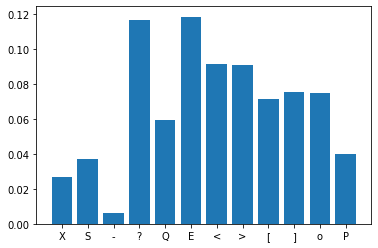

In [61]:
plt.bar(np.unique(tile_idx_errors), np.bincount(tile_idx_errors) / np.bincount(original_int.flatten()))
plt.xticks(np.unique(tile_idx_errors), [int2char_smb[i] for i in np.unique(tile_idx_errors)])
plt.show()

In [62]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [63]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [64]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [65]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(2698, 2698)

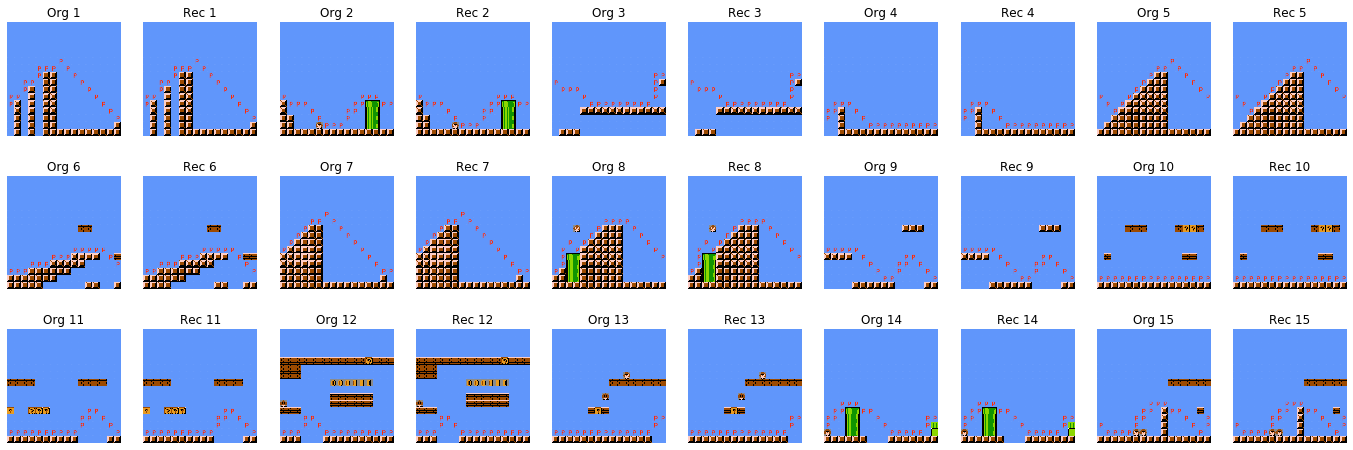

In [66]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

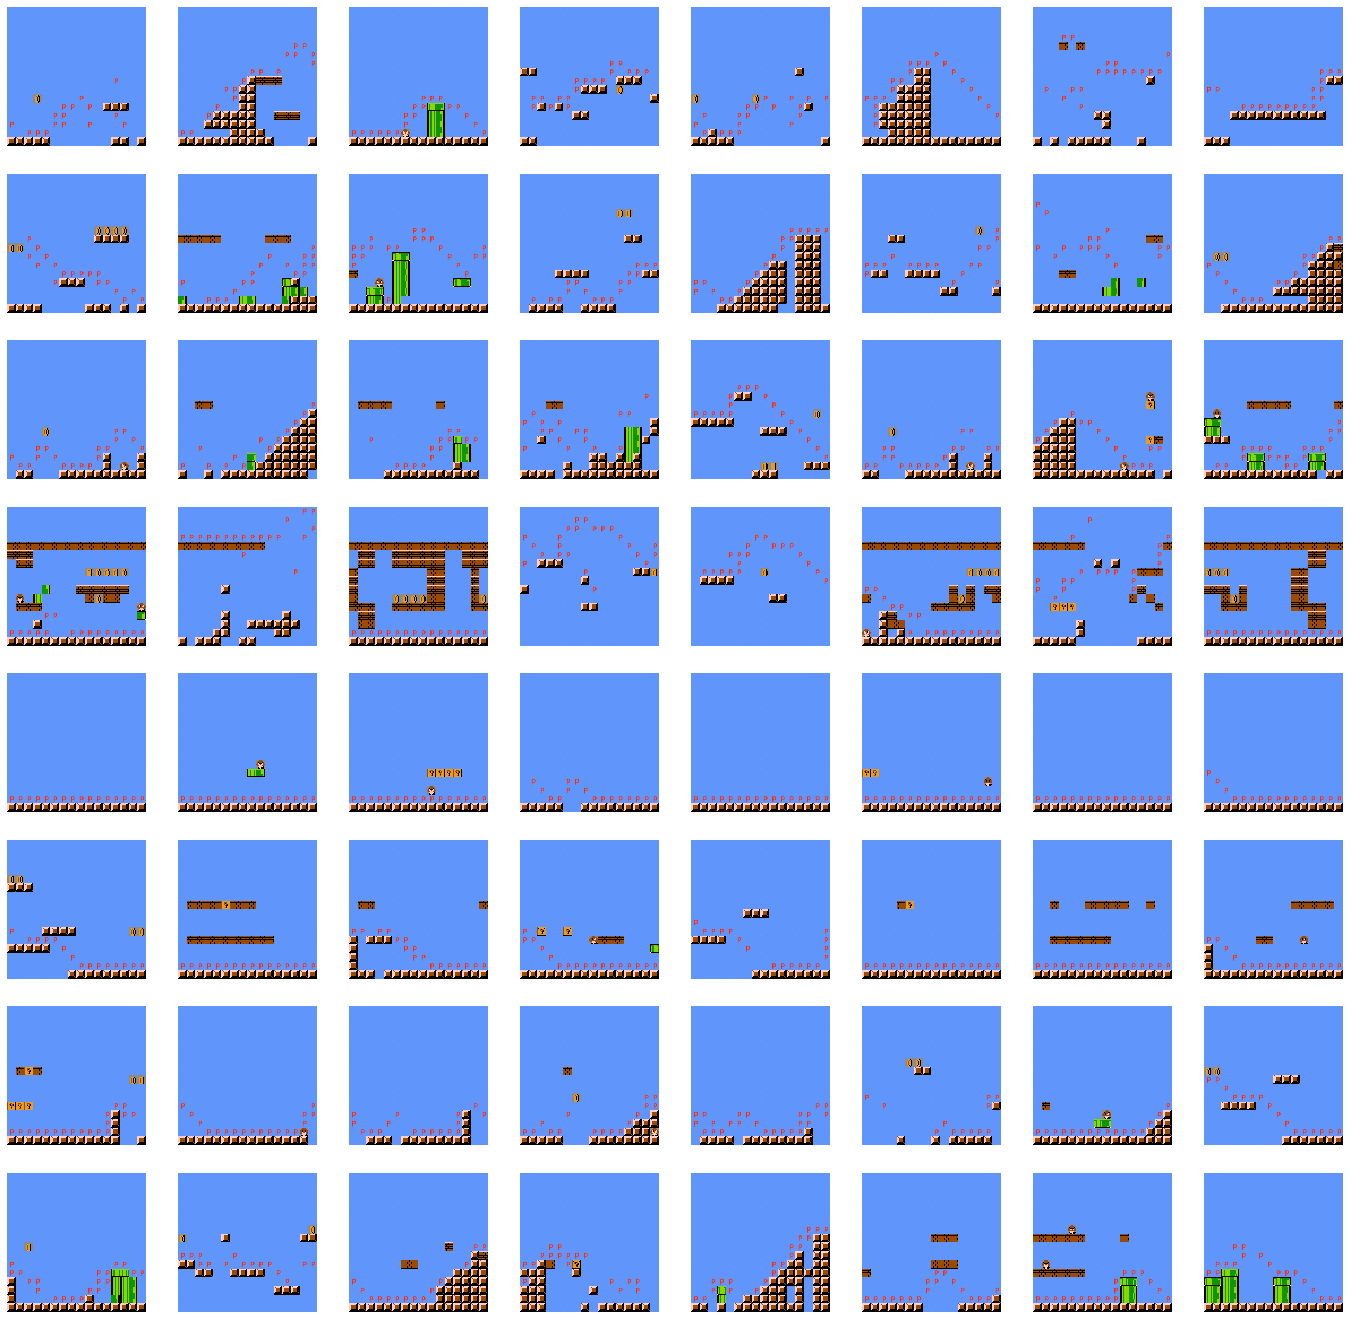

In [67]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 8
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [83]:
elem_per_category = 10000 // 8
generated = gmvae.random_generation(elem_per_category)

In [84]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [85]:
generated_int.shape

(10000, 16, 16)

In [86]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_gmvae_8_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [75]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

In [76]:
np.bincount(test_labels)

array([329, 304, 330, 436, 199, 257, 272, 301])

In [77]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [78]:
test_labels_subset = test_labels[:first_n]

In [79]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

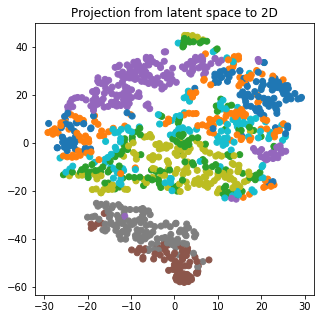

In [81]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_], c=test_labels_subset, cmap='tab10')

plt.title('Projection from latent space to 2D')
plt.show()